<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Owen_Myerson_combo_German_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 19.8 MB/s eta 0:00:00

LOADING AND PREPROCESSING GERMAN CREDIT DATASET
Dataset shape: (1000, 21)
Target distribution: {0: 700, 1: 300}
Default rate: 30.00%
Imbalance ratio: 2.33:1

Categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numeric columns (7): ['duration', 'credit_a

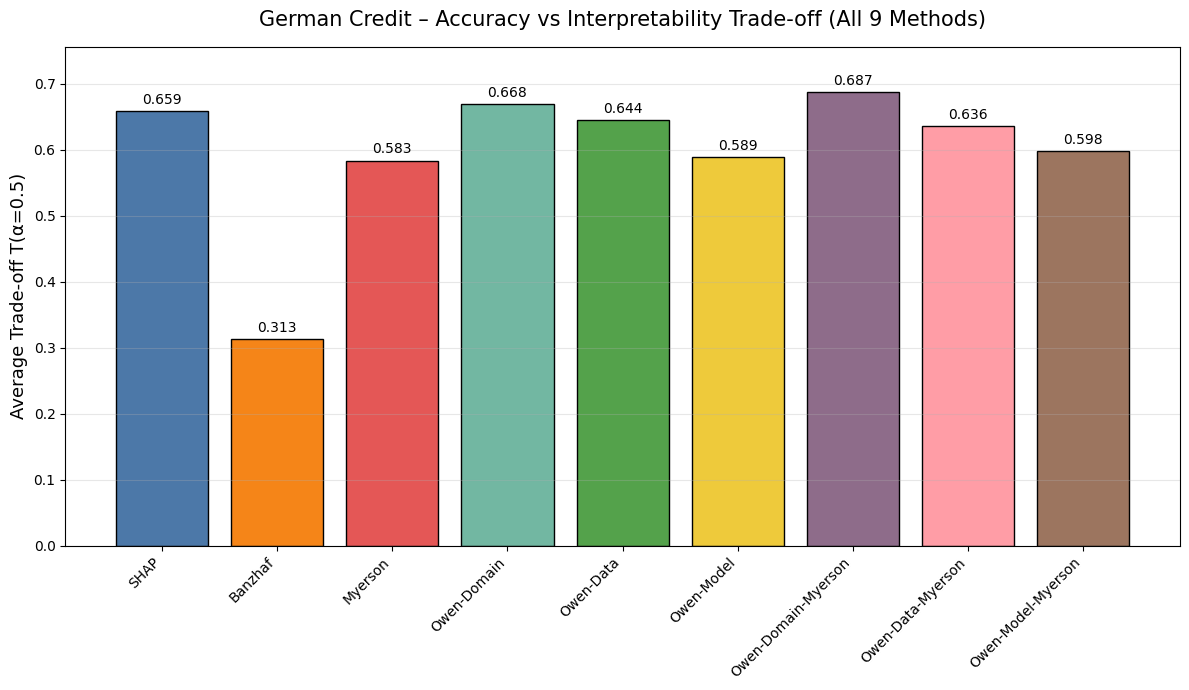

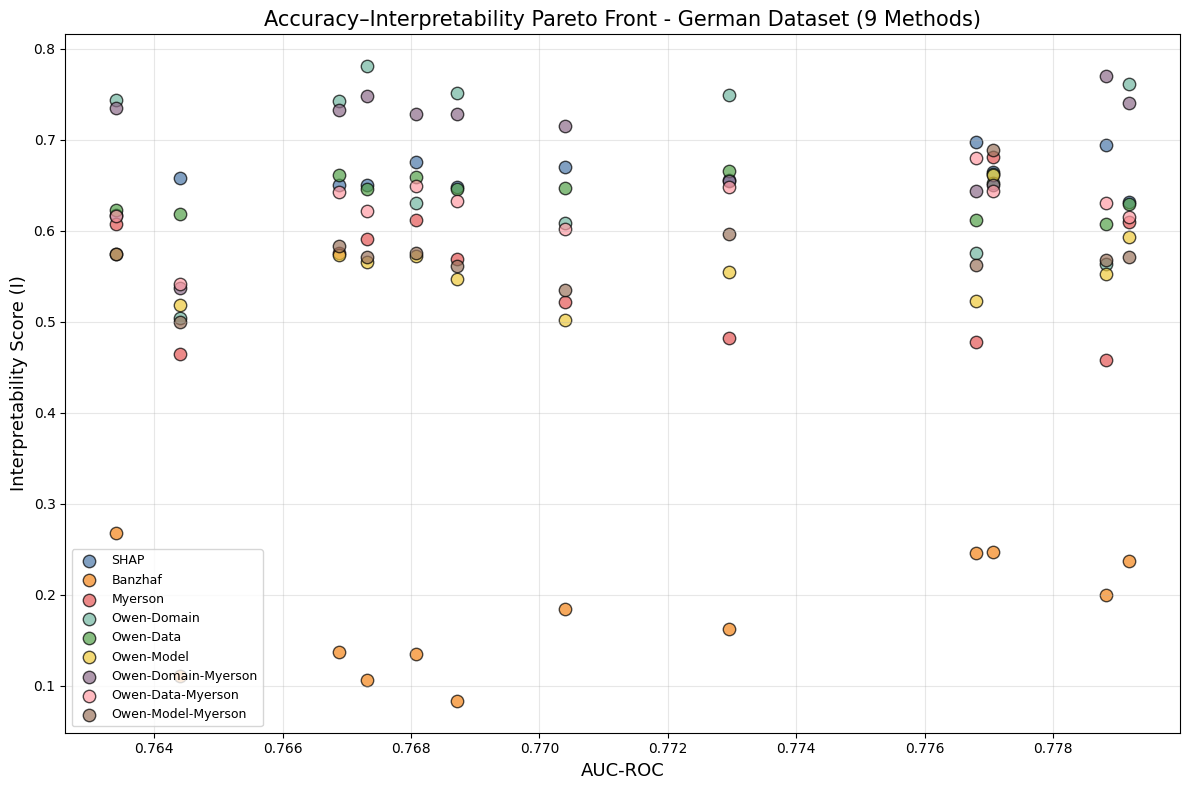

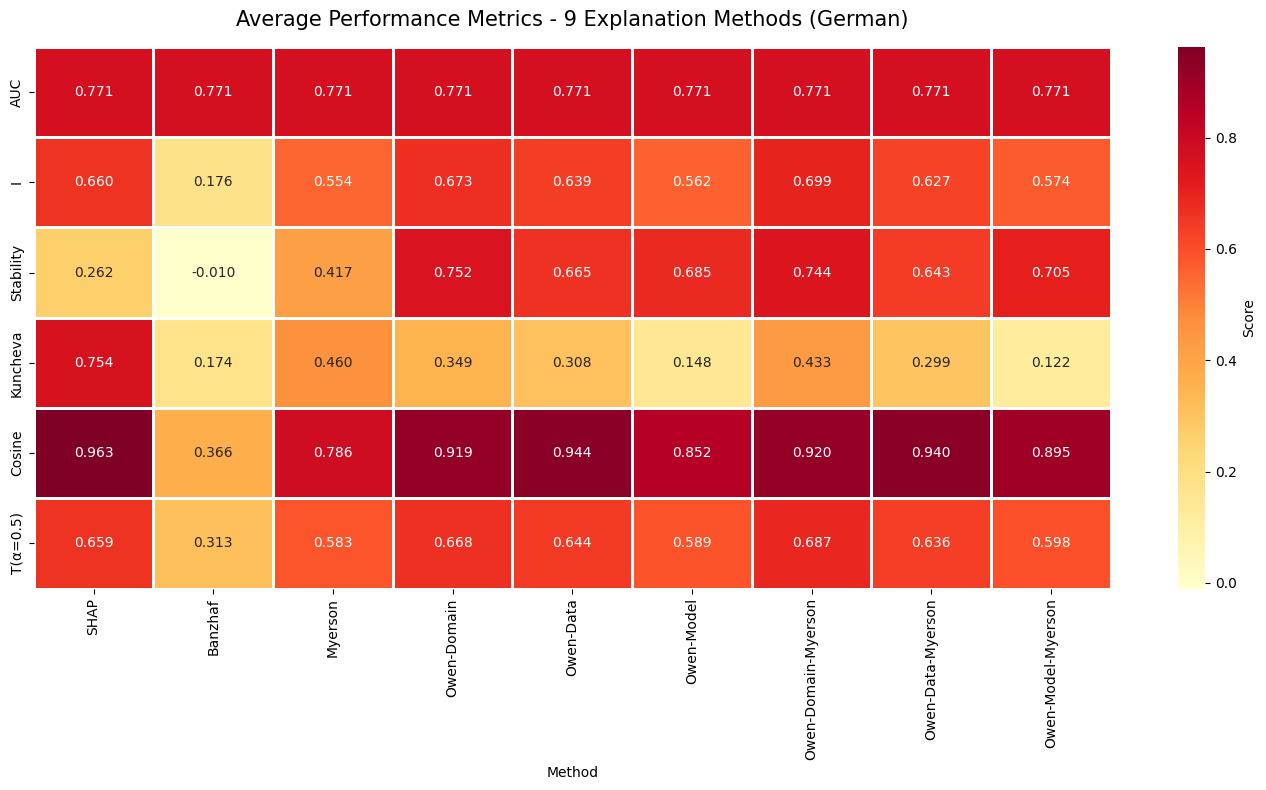


STATISTICAL ANALYSIS - ALL 9 METHODS

Friedman Test for T(α=0.5):
Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model', 'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson']
Friedman χ² = 67.2889, p = 0.000000
✓ SIGNIFICANT differences between methods

Nemenyi Post-Hoc Test (p-values):
        0       1       2       3       4       5       6       7       8
0  1.0000  0.0000  0.0136  1.0000  0.9963  0.0019  1.0000  0.6898  0.0365
1  0.0000  1.0000  0.3820  0.0000  0.0000  0.7379  0.0000  0.0025  0.2155
2  0.0136  0.3820  1.0000  0.0459  0.1536  0.9999  0.0136  0.7379  1.0000
3  1.0000  0.0000  0.0459  1.0000  1.0000  0.0080  1.0000  0.8920  0.1060
4  0.9963  0.0000  0.1536  1.0000  1.0000  0.0365  0.9963  0.9886  0.2920
5  0.0019  0.7379  0.9999  0.0080  0.0365  1.0000  0.0019  0.3820  0.9963
6  1.0000  0.0000  0.0136  1.0000  0.9963  0.0019  1.0000  0.6898  0.0365
7  0.6898  0.0025  0.7379  0.8920  0.9886  0.3820  0.6898  1.0000  0.89

In [1]:
# ============================================================
# GERMAN CREDIT DATASET - UNIFIED GAME THEORY EXPLAINABILITY
# WITH MYERSON–OWEN COMBOS
# ============================================================

!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy.spatial.distance import cosine
from sklearn.cluster import AgglomerativeClustering

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS GERMAN CREDIT DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING GERMAN CREDIT DATASET")
print("="*80)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1:0, 2:1})  # 1=good(0), 2=bad(1)

X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64']).columns.tolist()

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
fnames = preprocessor.get_feature_names_out()

print(f"\nNumber of processed features: {d}")
print(f"First 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                              verbose=-1, n_jobs=-1)
}

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (BASE + GROUPING)
# ============================================================
def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using fallback zeros...")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def build_feature_graph(preprocessor, X, threshold=0.25):
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)
    G = nx.Graph()
    d_graph = corr.shape[0]
    G.add_nodes_from(range(d_graph))
    for i in range(d_graph):
        for j in range(i+1, d_graph):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, corr

def compute_myerson(pipe, X_test, G, alpha=0.5):
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1))

def build_domain_groups_german(fnames):
    groups = {
        "CreditHistory": [],
        "FinancialStatus": [],
        "PersonalInfo": [],
        "LoanDetails": [],
        "Employment": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if "checking_status" in lname or "savings_status" in lname or "credit_history" in lname:
            groups["CreditHistory"].append(i)
        elif "credit_amount" in lname or "property_magnitude" in lname or "housing" in lname:
            groups["FinancialStatus"].append(i)
        elif "age" in lname or "personal_status" in lname or "num_dependents" in lname or "residence_since" in lname:
            groups["PersonalInfo"].append(i)
        elif "duration" in lname or "purpose" in lname or "installment_commitment" in lname:
            groups["LoanDetails"].append(i)
        elif "employment" in lname or "job" in lname:
            groups["Employment"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    d_local = len(phi)
    out = np.zeros(d_local)
    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

def compute_Q(groups, dep):
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)
        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)
        if across_mean == 0:
            return np.nan
        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS
# ============================================================
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())
    if len(sets) < 2:
        return 0.0
    ki_values = []
    d_local = expl_list[0].shape[1]
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)
    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    if len(expl_list) < 2:
        return 0.0
    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []
    for p in range(K):
        for s in range(p+1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos = 1 - cosine(v_p, v_s)
            cos_sims.append(cos)
    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (WITH MYERSON–OWEN)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 9 EXPLANATION METHODS")
print("="*80)

print("\nBuilding feature graph for Myerson value...")
X_proc = preprocessor.transform(X)
corr = np.corrcoef(X_proc.T)
G_myerson = nx.Graph()
d_graph = corr.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        owen_dom_myerson_runs, owen_data_myerson_runs, owen_model_myerson_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            X_sample = X_te.sample(n=min(30, len(X_te)), random_state=42)
            fnames = preprocessor.get_feature_names_out()

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_vals = np.zeros((len(X_sample), n_features))
                shap_runs.append(shap_vals)

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(3, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    myerson_vals = np.zeros((min(30, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_vals = np.zeros((min(30, len(X_sample)), n_features))
                myerson_runs.append(myerson_vals)

            # --- Myerson base vector for Owen combos ---
            phi_myerson = myerson_vals.mean(axis=0)

            # 4. Owen-Domain (SHAP-based)
            try:
                dom_groups = build_domain_groups_german(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(np.nan)

            # 4b. Owen-Domain-Myerson
            try:
                dom_groups = build_domain_groups_german(fnames)
                owen_dom_myerson = np.tile(owen_from_shap(phi_myerson, dom_groups), (len(X_sample), 1))
                owen_dom_myerson_runs.append(owen_dom_myerson)
            except Exception as e:
                print(f"  Owen-Domain-Myerson failed: {e}")
                owen_dom_myerson_runs.append(np.zeros((len(X_sample), d)))

            # 5. Owen-Data (SHAP-based)
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(np.nan)

            # 5b. Owen-Data-Myerson
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                owen_data_myerson = np.tile(owen_from_shap(phi_myerson, data_groups), (len(X_sample), 1))
                owen_data_myerson_runs.append(owen_data_myerson)
            except Exception as e:
                print(f"  Owen-Data-Myerson failed: {e}")
                owen_data_myerson_runs.append(np.zeros((len(X_sample), d)))

            # 6. Owen-Model (SHAP-based)
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(50, len(X_tr)), random_state=42)
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(np.nan)

            # 6b. Owen-Model-Myerson
            try:
                bg_sample = X_tr.sample(n=min(50, len(X_tr)), random_state=42)
                shap_bg = get_shap_reliable(pipe, bg_sample)
                model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                owen_model_myerson = np.tile(owen_from_shap(phi_myerson, model_groups), (len(X_sample), 1))
                owen_model_myerson_runs.append(owen_model_myerson)
            except Exception as e:
                print(f"  Owen-Model-Myerson failed: {e}")
                owen_model_myerson_runs.append(np.zeros((len(X_sample), d)))

        auc_mean = np.mean(aucs)

        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs),
            ('Owen-Domain-Myerson', owen_dom_myerson_runs),
            ('Owen-Data-Myerson', owen_data_myerson_runs),
            ('Owen-Model-Myerson', owen_model_myerson_runs)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan,
            # For Myerson-based Owen, reuse same Q (same groups)
            'Owen-Domain-Myerson': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data-Myerson': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model-Myerson': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'German',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
metrics = pd.DataFrame(all_records)
metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

print("\n" + "="*80)
print("COMPLETE RESULTS - ALL 9 EXPLANATION METHODS")
print("="*80)
print(metrics.round(4).to_string(index=False))

metrics.to_csv('german_unified_results_myerson_owen.csv', index=False)
print("\n✓ Results saved to: german_unified_results_myerson_owen.csv")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

colors = {
    'SHAP': '#4C78A8',
    'Banzhaf': '#F58518',
    'Myerson': '#E45756',
    'Owen-Domain': '#72B7A2',
    'Owen-Data': '#54A24B',
    'Owen-Model': '#EECA3B',
    'Owen-Domain-Myerson': '#8E6C8A',
    'Owen-Data-Myerson': '#FF9DA6',
    'Owen-Model-Myerson': '#9C755F'
}

method_order = [
    'SHAP', 'Banzhaf', 'Myerson',
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

# 1. Average Trade-off by Method
plt.figure(figsize=(12, 7))
method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
bars = plt.bar(method_avg.index, method_avg.values,
               color=[colors[m] for m in method_avg.index], edgecolor='black')
plt.bar_label(bars, fmt='%.3f', fontsize=10, padding=3)
plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
plt.title("German Credit – Accuracy vs Interpretability Trade-off (All 9 Methods)",
          fontsize=15, pad=15)
plt.ylim(0, method_avg.max() * 1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_all_methods_tradeoff_myerson_owen.png', dpi=300)
plt.show()

# 2. Pareto Front: AUC vs I
plt.figure(figsize=(12, 8))
for method in method_order:
    if method in metrics['Method'].unique():
        sub = metrics[metrics['Method'] == method]
        plt.scatter(sub['AUC'], sub['I'], s=80, label=method,
                   color=colors[method], alpha=0.7, edgecolors='black')
plt.xlabel("AUC-ROC", fontsize=13)
plt.ylabel("Interpretability Score (I)", fontsize=13)
plt.title("Accuracy–Interpretability Pareto Front - German Dataset (9 Methods)", fontsize=15)
plt.legend(fontsize=9, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('german_all_methods_pareto_myerson_owen.png', dpi=300)
plt.show()

# 3. Heatmap of average metrics
plt.figure(figsize=(14, 8))
heatmap_data = metrics.groupby('Method').agg({
    'AUC': 'mean',
    'I': 'mean',
    'Stability': 'mean',
    'Kuncheva': 'mean',
    'Cosine': 'mean',
    'T(α=0.5)': 'mean'
}).reindex(method_order).T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
plt.title("Average Performance Metrics - 9 Explanation Methods (German)", fontsize=15, pad=15)
plt.tight_layout()
plt.savefig('german_all_methods_heatmap_myerson_owen.png', dpi=300)
plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 9 METHODS")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp

print("\nFriedman Test for T(α=0.5):")
pivoted = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method',
    aggfunc='mean'
)

complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
complete_methods = [m for m in method_order if m in complete_methods]

if len(complete_methods) >= 3:
    data_matrix = pivoted[complete_methods].values
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])
    print(f"Methods compared: {complete_methods}")
    print(f"Friedman χ² = {stat:.4f}, p = {p_value:.6f}")
    if p_value < 0.05:
        print("✓ SIGNIFICANT differences between methods")
        nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)
        print("\nNemenyi Post-Hoc Test (p-values):")
        print(nemenyi_results.round(4))
    else:
        print("✗ No significant differences")
else:
    print("Insufficient complete data for Friedman test")

print("\nPairwise Wilcoxon Tests for T(α=0.5):")
key_pairs = [
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('SHAP', 'Owen-Domain-Myerson'),
    ('SHAP', 'Owen-Data-Myerson'),
    ('SHAP', 'Owen-Model-Myerson'),
    ('Owen-Domain', 'Owen-Domain-Myerson'),
    ('Owen-Data', 'Owen-Data-Myerson'),
    ('Owen-Model', 'Owen-Model-Myerson')
]

for method1, method2 in key_pairs:
    if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values
        if len(data1) > 1 and len(data2) > 1 and len(data1) == len(data2):
            try:
                stat, p_value = wilcoxon(data1, data2)
                mean1, mean2 = np.mean(data1), np.mean(data2)
                sig = "✓" if p_value < 0.05 else "✗"
                print(f"{method1} vs {method2}: p={p_value:.4f} (means: {mean1:.3f} vs {mean2:.3f}) {sig}")
            except Exception as e:
                print(f"{method1} vs {method2}: Could not compute ({e})")

print("\n" + "="*80)
print("UNIFIED EXPERIMENT WITH MYERSON–OWEN COMBOS COMPLETE!")
print("="*80)


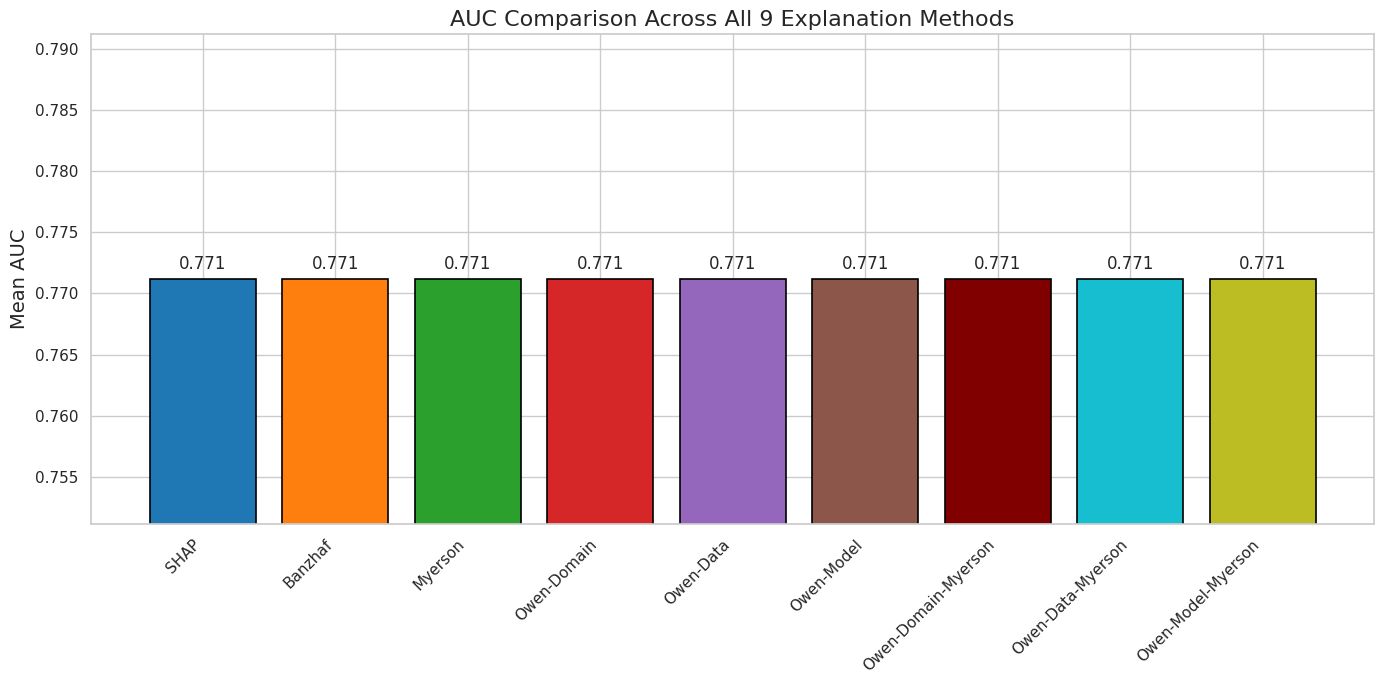

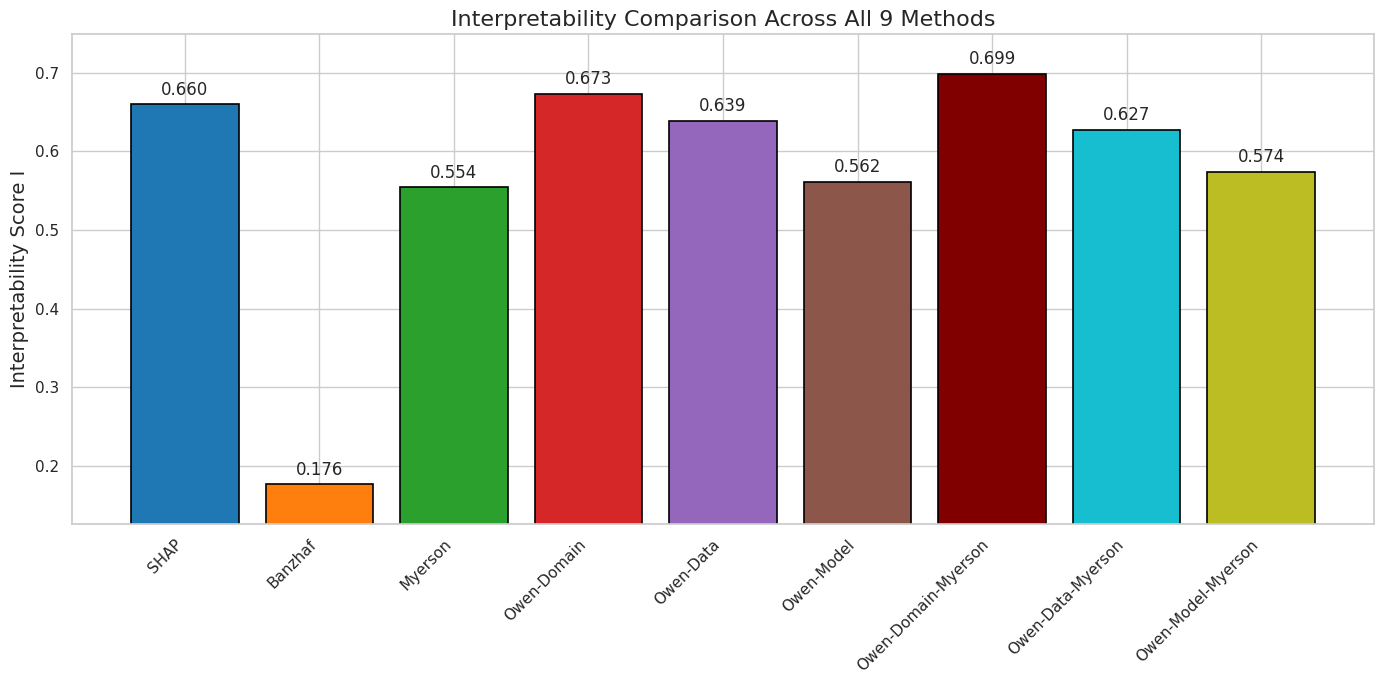

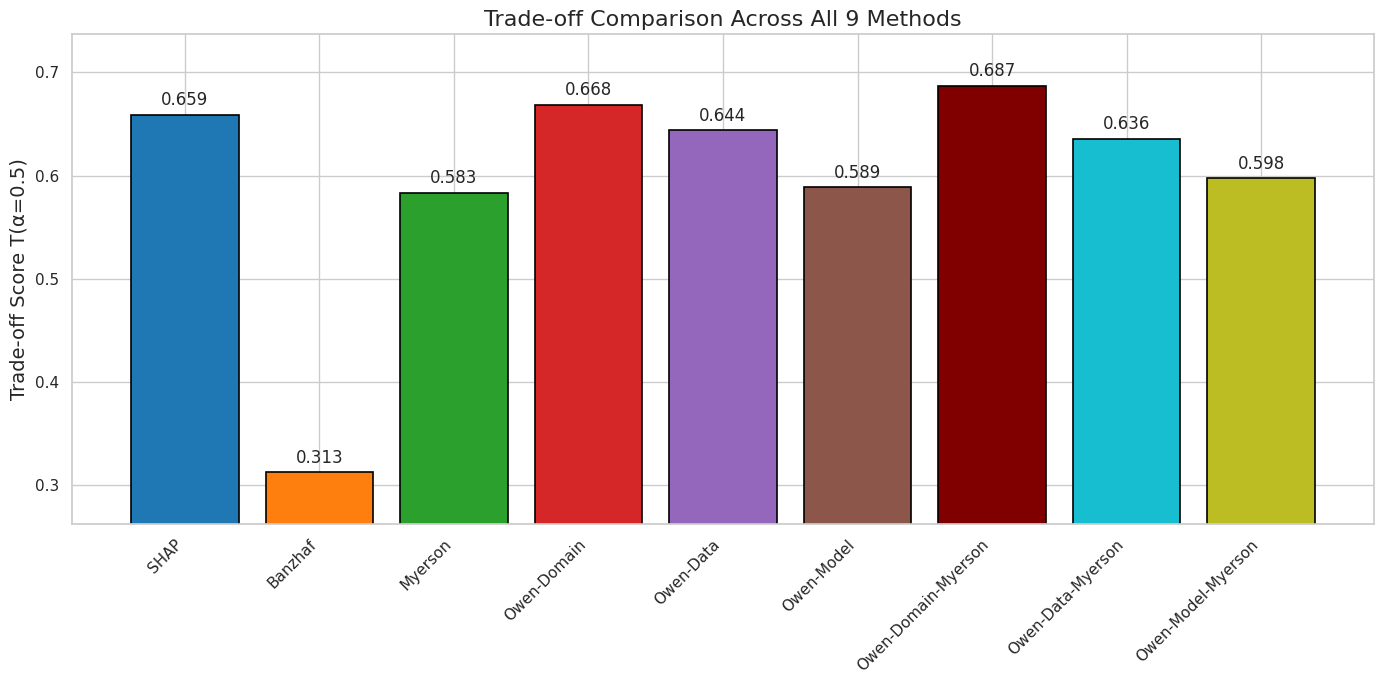

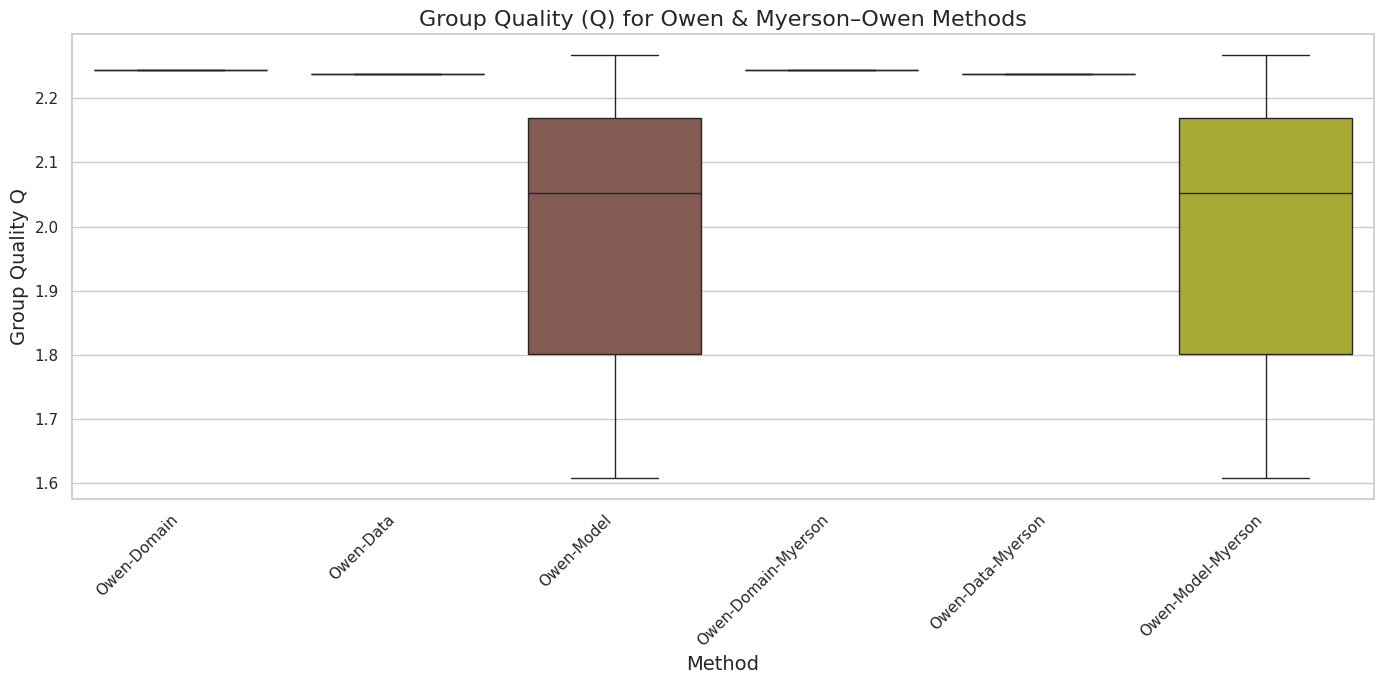

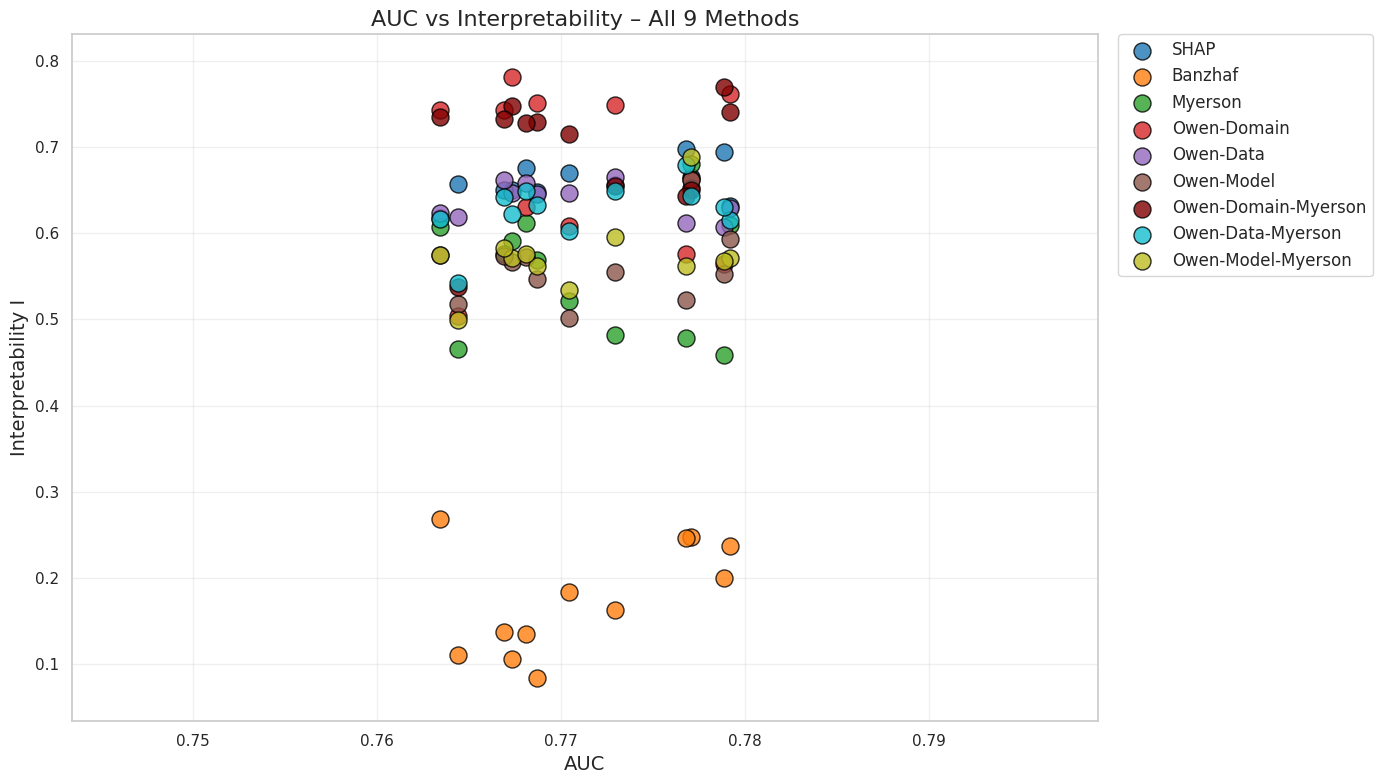

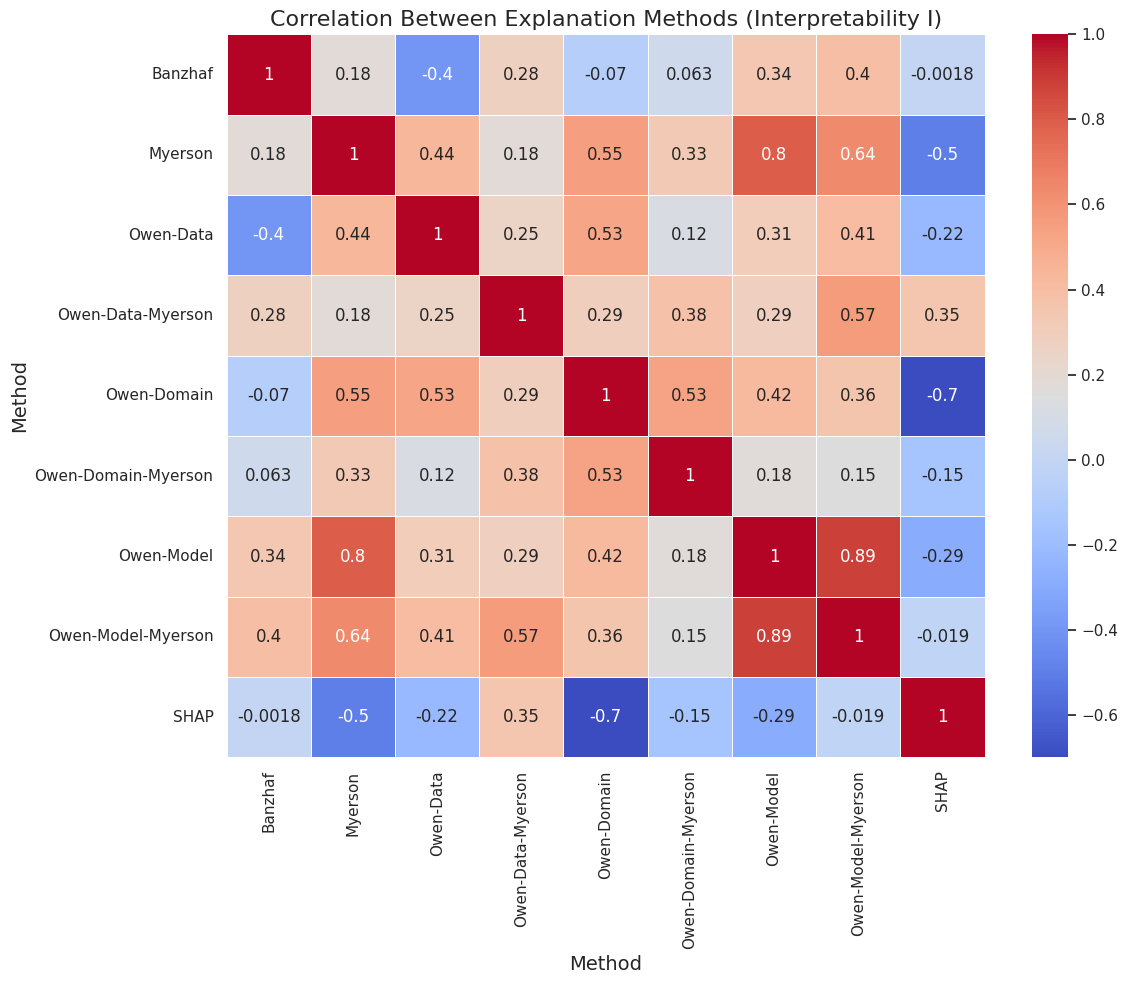

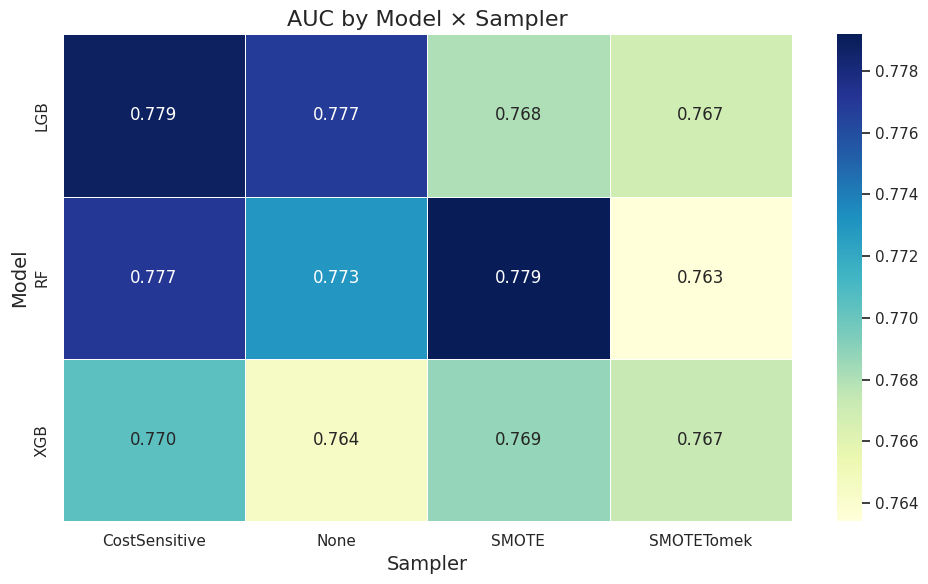

In [5]:
# ============================================================
# BEAUTIFUL THESIS-READY VISUALIZATION MODULE
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "figure.figsize": (12, 6)
})

# ------------------------------------------------------------
# Method ordering and colors (distinct, clean palette)
# ------------------------------------------------------------
method_order = [
    'SHAP', 'Banzhaf', 'Myerson',
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

method_colors = {
    'SHAP': '#1f77b4',
    'Banzhaf': '#ff7f0e',
    'Myerson': '#2ca02c',
    'Owen-Domain': '#d62728',            # RED
    'Owen-Data': '#9467bd',
    'Owen-Model': '#8c564b',
    'Owen-Domain-Myerson': '#800000',    # DARK RED
    'Owen-Data-Myerson': '#17becf',
    'Owen-Model-Myerson': '#bcbd22'
}

# ============================================================
# 1. AUC COMPARISON (clean bar chart)
# ============================================================

plt.figure(figsize=(14, 7))
auc_means = metrics_g.groupby("Method")["AUC"].mean().reindex(method_order)

bars = plt.bar(
    auc_means.index,
    auc_means.values,
    color=[method_colors[m] for m in auc_means.index],
    edgecolor='black',
    linewidth=1.2
)

plt.bar_label(bars, fmt="%.3f", padding=4)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean AUC")
plt.title("AUC Comparison Across All 9 Explanation Methods")
plt.ylim(auc_means.min() - 0.02, auc_means.max() + 0.02)
plt.tight_layout()
plt.show()

# ============================================================
# 2. INTERPRETABILITY COMPARISON
# ============================================================

plt.figure(figsize=(14, 7))
I_means = metrics_g.groupby("Method")["I"].mean().reindex(method_order)

bars = plt.bar(
    I_means.index,
    I_means.values,
    color=[method_colors[m] for m in I_means.index],
    edgecolor='black',
    linewidth=1.2
)

plt.bar_label(bars, fmt="%.3f", padding=4)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Interpretability Score I")
plt.title("Interpretability Comparison Across All 9 Methods")
plt.ylim(I_means.min() - 0.05, I_means.max() + 0.05)
plt.tight_layout()
plt.show()

# ============================================================
# 3. TRADE-OFF T(α=0.5) COMPARISON
# ============================================================

plt.figure(figsize=(14, 7))
T_means = metrics_g.groupby("Method")["T(α=0.5)"].mean().reindex(method_order)

bars = plt.bar(
    T_means.index,
    T_means.values,
    color=[method_colors[m] for m in T_means.index],
    edgecolor='black',
    linewidth=1.2
)

plt.bar_label(bars, fmt="%.3f", padding=4)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Trade-off Score T(α=0.5)")
plt.title("Trade-off Comparison Across All 9 Methods")
plt.ylim(T_means.min() - 0.05, T_means.max() + 0.05)
plt.tight_layout()
plt.show()

# ============================================================
# 4. GROUP QUALITY Q (Owen + Myerson-Owen)
# ============================================================

owen_methods = [
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

owen_data = metrics_g[metrics_g["Method"].isin(owen_methods)]

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=owen_data,
    x="Method",
    y="Q",
    order=owen_methods,
    palette=[method_colors[m] for m in owen_methods]
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Group Quality Q")
plt.title("Group Quality (Q) for Owen & Myerson–Owen Methods")
plt.tight_layout()
plt.show()

# ============================================================
# 5. AUC vs I SCATTER (clean, large markers, legend outside)
# ============================================================

plt.figure(figsize=(14, 8))

for m in method_order:
    sub = metrics_g[metrics_g["Method"] == m]
    plt.scatter(
        sub["AUC"],
        sub["I"],
        label=m,
        color=method_colors[m],
        edgecolors='black',
        alpha=0.8,
        s=150
    )

plt.xlabel("AUC")
plt.ylabel("Interpretability I")
plt.title("AUC vs Interpretability – All 9 Methods")

plt.xlim(metrics_g["AUC"].min() - 0.02, metrics_g["AUC"].max() + 0.02)
plt.ylim(metrics_g["I"].min() - 0.05, metrics_g["I"].max() + 0.05)

plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 6. METHOD CORRELATION HEATMAP (NEW)
# ============================================================

pivot_I = metrics_g.pivot_table(
    values="I",
    index=["Model", "Sampler"],
    columns="Method"
)

corr_matrix = pivot_I.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='white'
)
plt.title("Correlation Between Explanation Methods (Interpretability I)")
plt.tight_layout()
plt.show()

# ============================================================
# 7. MODEL × SAMPLER HEATMAP (AUC)
# ============================================================

plt.figure(figsize=(10, 6))
ms_auc = metrics_g.groupby(['Model', 'Sampler'])['AUC'].mean().reset_index()
ms_auc_pivot = ms_auc.pivot(index='Model', columns='Sampler', values='AUC')

sns.heatmap(
    ms_auc_pivot,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white'
)

plt.title("AUC by Model × Sampler")
plt.tight_layout()
plt.show()


Using existing 'metrics' DataFrame.

Metrics shape: (108, 12)
  Dataset Model Sampler       Method       AUC        CV  Stability  Kuncheva  \
0  German    RF    None         SHAP  0.772952  0.713028   0.286972  0.709767   
1  German    RF    None      Banzhaf  0.772952  1.030827  -0.030827  0.151628   
2  German    RF    None      Myerson  0.772952  0.623424   0.376576  0.330233   
3  German    RF    None  Owen-Domain  0.772952  0.232520   0.767480  0.553488   
4  German    RF    None    Owen-Data  0.772952  0.290846   0.709154  0.330233   

     Cosine         I         Q  T(α=0.5)  
0  0.972549  0.656429       NaN  0.713026  
1  0.366181  0.162327       NaN  0.358961  
2  0.739204  0.482004       NaN  0.588036  
3  0.926048  0.749005  2.243614  0.779364  
4  0.957889  0.665759  2.237074  0.719711  


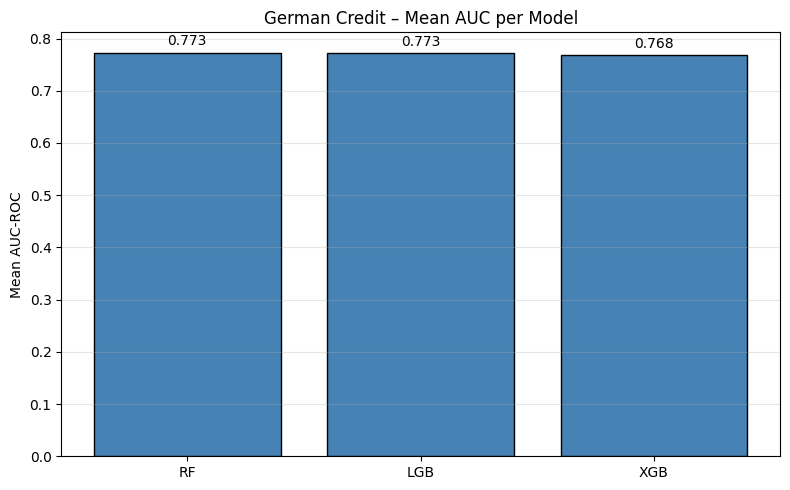

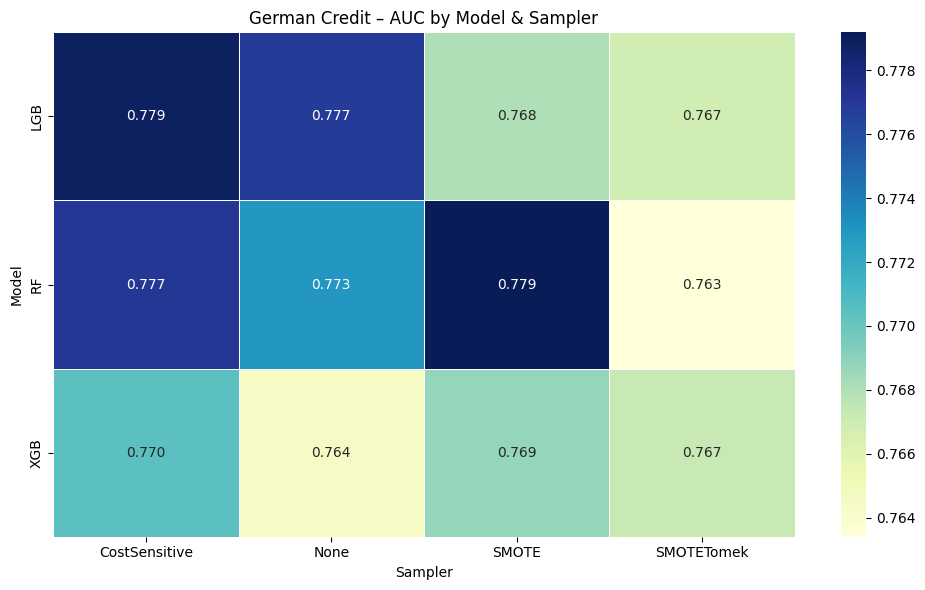

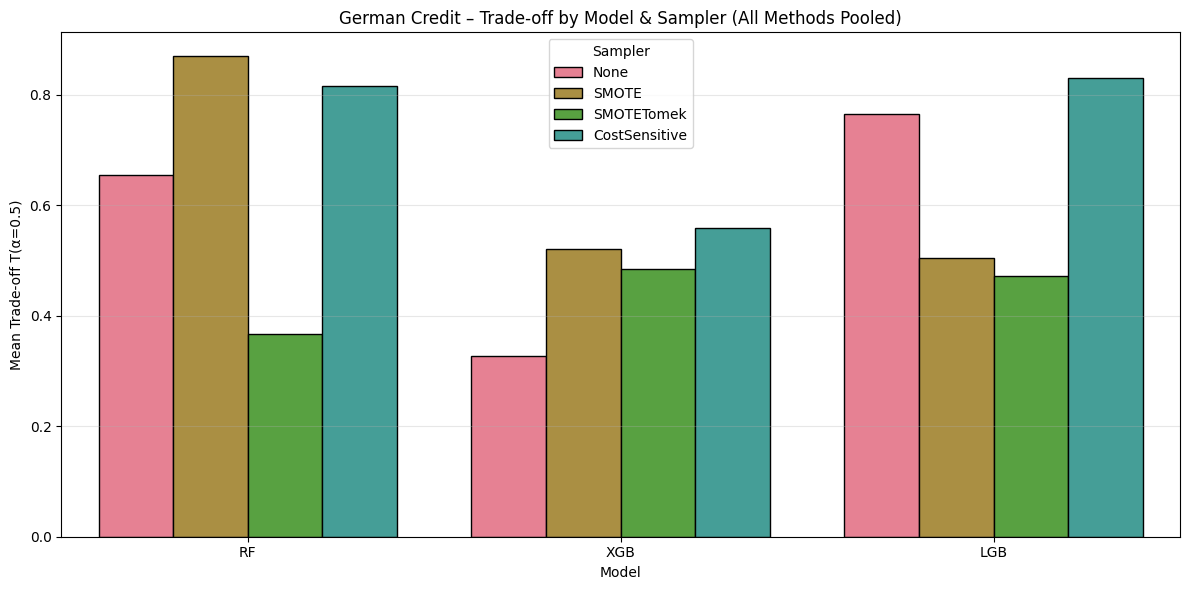

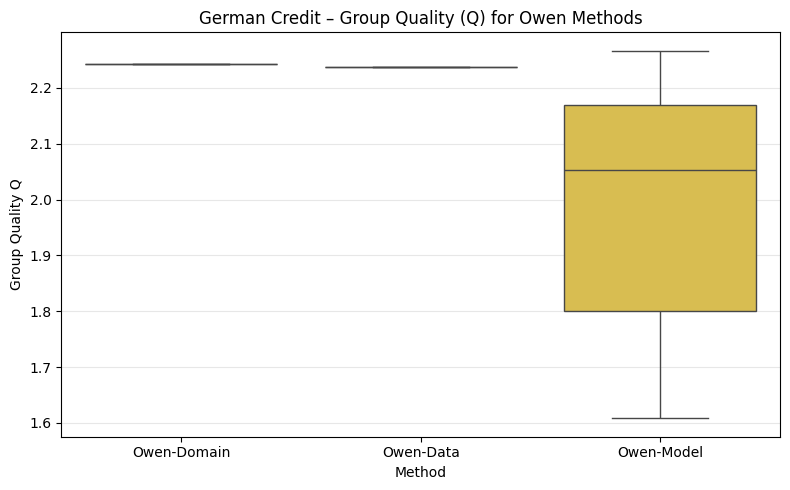

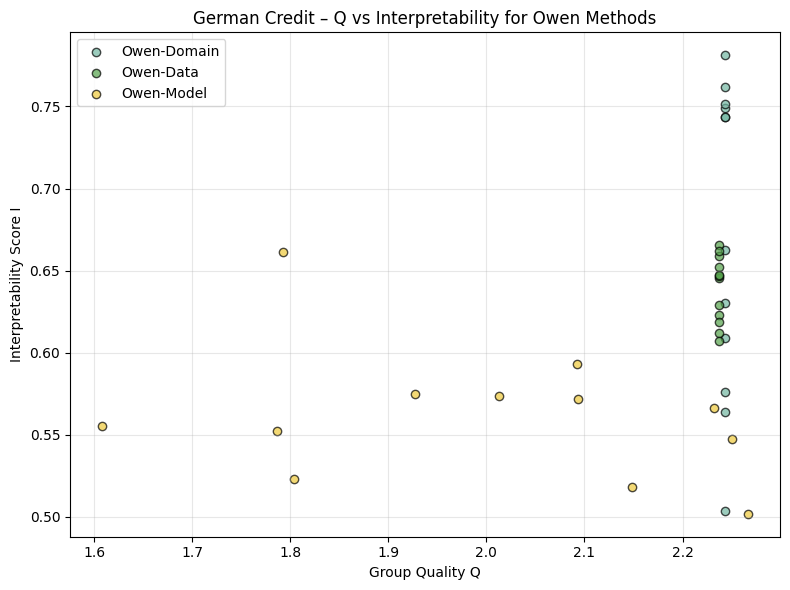

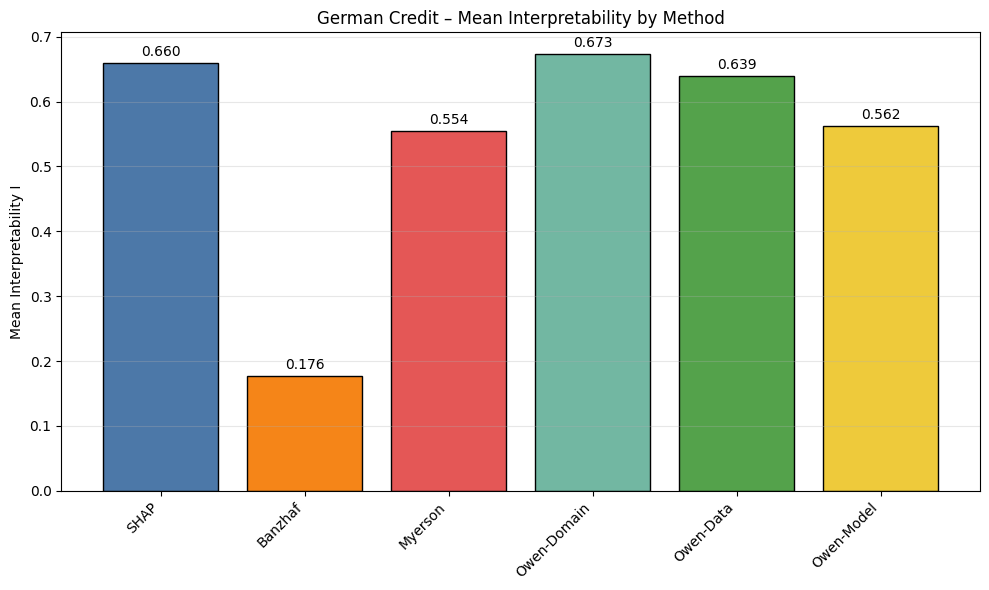

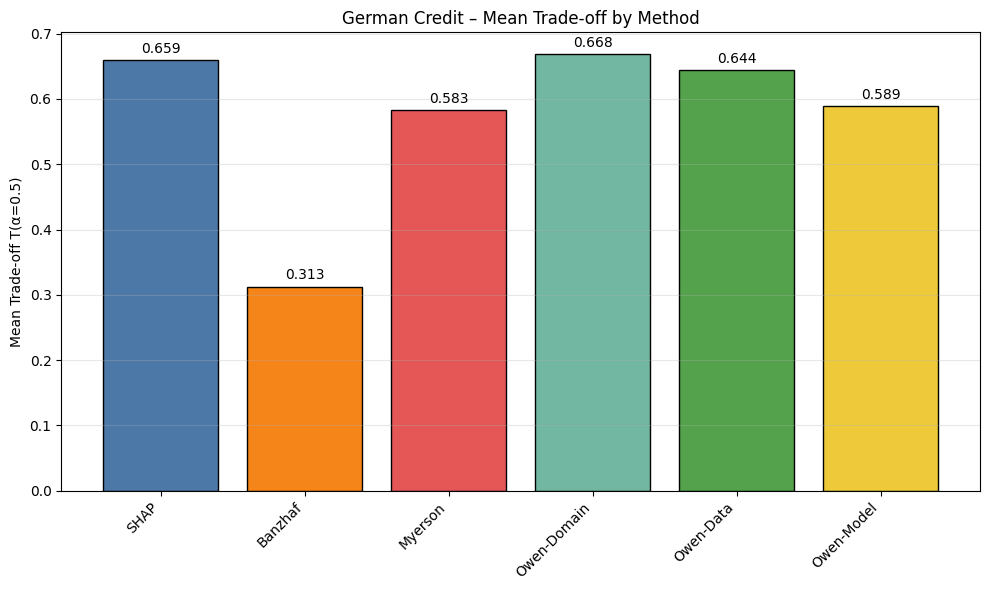

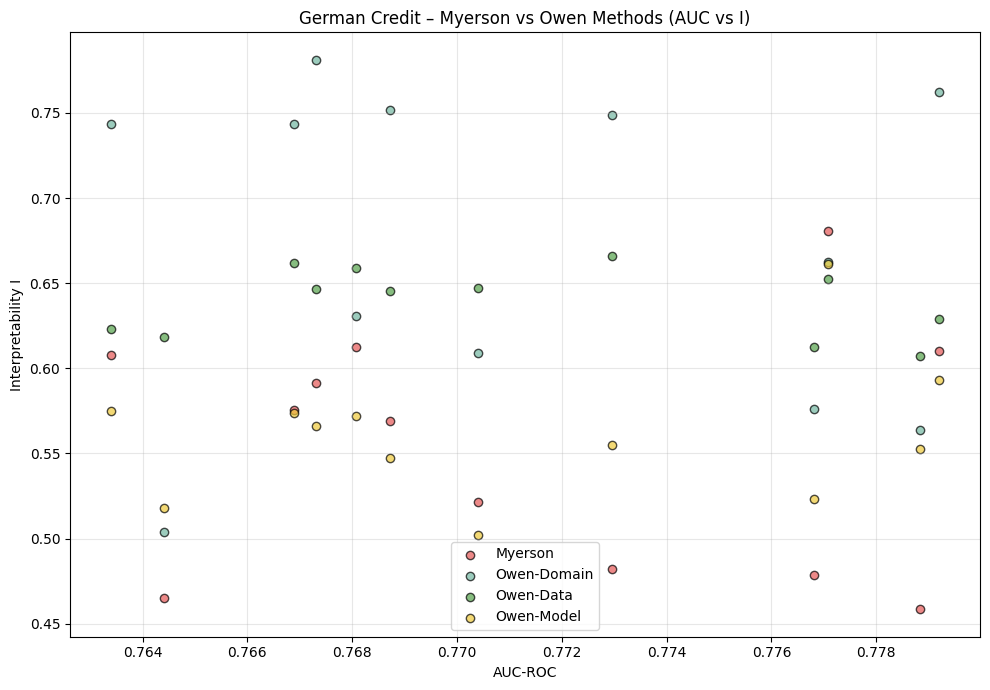

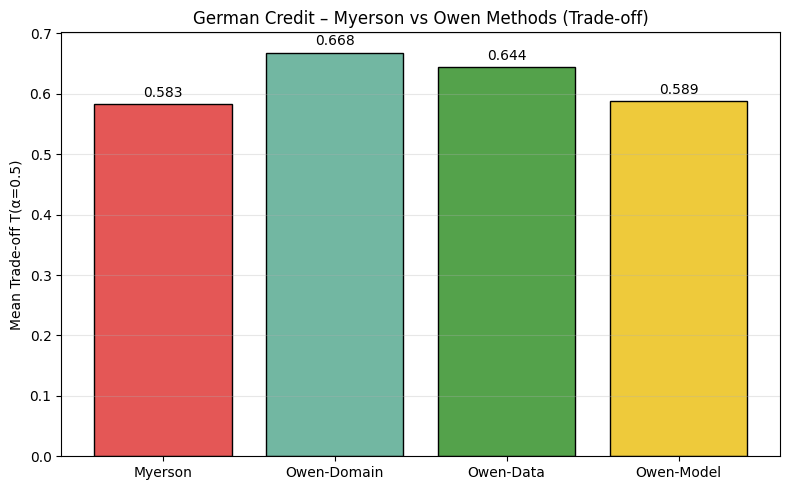


STATISTICAL VALIDATION – GERMAN DATASET

Spearman correlation between AUC and I:
ρ = 0.0758, p = 0.435581

Cliff's Delta for T(α=0.5) – SHAP vs other methods:
SHAP vs Banzhaf: δ = 0.7361 (large)
SHAP vs Myerson: δ = 0.2639 (small)
SHAP vs Owen-Domain: δ = -0.0417 (negligible)
SHAP vs Owen-Data: δ = 0.0972 (negligible)
SHAP vs Owen-Model: δ = 0.2917 (small)

Pairwise Wilcoxon tests for T(α=0.5):
SHAP vs Banzhaf: W = 0.0000, p = 0.000488 (SIGNIFICANT)
SHAP vs Myerson: W = 2.0000, p = 0.001465 (SIGNIFICANT)
SHAP vs Owen-Domain: W = 35.0000, p = 0.791016 (ns)
SHAP vs Owen-Data: W = 15.0000, p = 0.063965 (ns)
SHAP vs Owen-Model: W = 0.0000, p = 0.000488 (SIGNIFICANT)
Owen-Domain vs Owen-Data: W = 23.0000, p = 0.233398 (ns)
Owen-Domain vs Owen-Model: W = 3.0000, p = 0.002441 (SIGNIFICANT)

Friedman test on T(α=0.5) across methods:
Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 45.8571, p = 0.000000
→ Significant differences between m

In [2]:
# ============================================================
# 9. ANALYSIS & PLOTS MODULE (GERMAN DATASET)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare
import scikit_posthocs as sp

plt.style.use('default')
sns.set_palette("husl")

# ------------------------------------------------------------
# Load metrics if not already in memory
# ------------------------------------------------------------
try:
    metrics
    print("Using existing 'metrics' DataFrame.")
except NameError:
    print("Loading metrics from 'german_unified_results_fixed.csv'...")
    metrics = pd.read_csv('german_unified_results_fixed.csv')

# Ensure we only work with German dataset if multiple exist
if 'Dataset' in metrics.columns:
    metrics_g = metrics[metrics['Dataset'] == 'German'].copy()
else:
    metrics_g = metrics.copy()

print("\nMetrics shape:", metrics_g.shape)
print(metrics_g.head())

# Color map for methods
method_colors = {
    'SHAP': '#4C78A8',
    'Banzhaf': '#F58518',
    'Myerson': '#E45756',
    'Owen-Domain': '#72B7A2',
    'Owen-Data': '#54A24B',
    'Owen-Model': '#EECA3B'
}
method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

# ============================================================
# A. MODEL-LEVEL PERFORMANCE PLOTS
# ============================================================

# 1. AUC per model (averaged over samplers & methods)
plt.figure(figsize=(8, 5))
model_auc = metrics_g.groupby('Model')['AUC'].mean().sort_values(ascending=False)
bars = plt.bar(model_auc.index, model_auc.values, color='steelblue', edgecolor='black')
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.ylabel("Mean AUC-ROC")
plt.title("German Credit – Mean AUC per Model")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_auc_per_model.png', dpi=300)
plt.show()

# 2. AUC per Model–Sampler combination (averaged over methods)
plt.figure(figsize=(10, 6))
ms_auc = metrics_g.groupby(['Model', 'Sampler'])['AUC'].mean().reset_index()
ms_auc_pivot = ms_auc.pivot(index='Model', columns='Sampler', values='AUC')
sns.heatmap(ms_auc_pivot, annot=True, fmt='.3f', cmap='YlGnBu', linewidths=0.5, linecolor='white')
plt.title("German Credit – AUC by Model & Sampler")
plt.tight_layout()
plt.savefig('german_auc_model_sampler_heatmap.png', dpi=300)
plt.show()

# 3. Trade-off T(α=0.5) per Model–Sampler–Method
plt.figure(figsize=(12, 6))
sns.barplot(
    data=metrics_g,
    x='Model',
    y='T(α=0.5)',
    hue='Sampler',
    ci=None,
    edgecolor='black'
)
plt.ylabel("Mean Trade-off T(α=0.5)")
plt.title("German Credit – Trade-off by Model & Sampler (All Methods Pooled)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_tradeoff_model_sampler.png', dpi=300)
plt.show()

# ============================================================
# B. GROUP QUALITY (Q) ANALYSIS FOR OWEN METHODS
# ============================================================

owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
owen_data = metrics_g[metrics_g['Method'].isin(owen_methods)].copy()

# 1. Distribution of Q per Owen method
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=owen_data,
    x='Method',
    y='Q',
    order=owen_methods,
    palette=[method_colors[m] for m in owen_methods]
)
plt.ylabel("Group Quality Q")
plt.title("German Credit – Group Quality (Q) for Owen Methods")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_owen_group_quality_boxplot.png', dpi=300)
plt.show()

# 2. Q vs Interpretability I for Owen methods
plt.figure(figsize=(8, 6))
for m in owen_methods:
    sub = owen_data[owen_data['Method'] == m]
    plt.scatter(
        sub['Q'], sub['I'],
        label=m,
        color=method_colors[m],
        alpha=0.7,
        edgecolors='black'
    )
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability Score I")
plt.title("German Credit – Q vs Interpretability for Owen Methods")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('german_owen_q_vs_i.png', dpi=300)
plt.show()

# ============================================================
# C. SEPARATE OWEN ANALYSIS (I & T)
# ============================================================

# 1. Average I per method (Owen vs others)
plt.figure(figsize=(10, 6))
method_I = metrics_g.groupby('Method')['I'].mean().reindex(method_order)
bars = plt.bar(method_I.index, method_I.values,
               color=[method_colors[m] for m in method_I.index],
               edgecolor='black')
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.ylabel("Mean Interpretability I")
plt.title("German Credit – Mean Interpretability by Method")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_mean_I_by_method.png', dpi=300)
plt.show()

# 2. Average T(α=0.5) per method (already similar to your plot, but kept here)
plt.figure(figsize=(10, 6))
method_T = metrics_g.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
bars = plt.bar(method_T.index, method_T.values,
               color=[method_colors[m] for m in method_T.index],
               edgecolor='black')
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.ylabel("Mean Trade-off T(α=0.5)")
plt.title("German Credit – Mean Trade-off by Method")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_mean_T_by_method.png', dpi=300)
plt.show()

# ============================================================
# D. OWEN–MYERSON COMPARISON
# ============================================================

subset_methods = ['Myerson'] + owen_methods
sub_data = metrics_g[metrics_g['Method'].isin(subset_methods)].copy()

# 1. AUC vs I scatter for Myerson + Owen methods
plt.figure(figsize=(10, 7))
for m in subset_methods:
    sub = sub_data[sub_data['Method'] == m]
    plt.scatter(
        sub['AUC'], sub['I'],
        label=m,
        color=method_colors[m],
        alpha=0.7,
        edgecolors='black'
    )
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title("German Credit – Myerson vs Owen Methods (AUC vs I)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('german_myerson_owen_auc_vs_i.png', dpi=300)
plt.show()

# 2. T(α=0.5) comparison for Myerson + Owen methods
plt.figure(figsize=(8, 5))
comp_T = sub_data.groupby('Method')['T(α=0.5)'].mean().reindex(subset_methods)
bars = plt.bar(comp_T.index, comp_T.values,
               color=[method_colors[m] for m in comp_T.index],
               edgecolor='black')
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.ylabel("Mean Trade-off T(α=0.5)")
plt.title("German Credit – Myerson vs Owen Methods (Trade-off)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('german_myerson_owen_T.png', dpi=300)
plt.show()

# ============================================================
# E. STATISTICAL VALIDATION
# ============================================================

print("\n" + "="*80)
print("STATISTICAL VALIDATION – GERMAN DATASET")
print("="*80)

# ------------------------------------------------------------
# 1. Spearman correlation between AUC and I
# ------------------------------------------------------------
rho, pval = spearmanr(metrics_g['AUC'], metrics_g['I'])
print(f"\nSpearman correlation between AUC and I:")
print(f"ρ = {rho:.4f}, p = {pval:.6f}")

# ------------------------------------------------------------
# 2. Cliff's Delta implementation
# ------------------------------------------------------------
def cliffs_delta(x, y):
    """
    Compute Cliff's delta effect size between two arrays.
    Returns (delta, magnitude_label).
    """
    x = np.array(x)
    y = np.array(y)
    n1 = len(x)
    n2 = len(y)
    # All pairwise comparisons
    greater = 0
    less = 0
    for xi in x:
        greater += np.sum(xi > y)
        less += np.sum(xi < y)
    delta = (greater - less) / (n1 * n2)
    ad = abs(delta)
    if ad < 0.147:
        mag = "negligible"
    elif ad < 0.33:
        mag = "small"
    elif ad < 0.474:
        mag = "medium"
    else:
        mag = "large"
    return delta, mag

print("\nCliff's Delta for T(α=0.5) – SHAP vs other methods:")
base = 'SHAP'
for m in method_order:
    if m == base:
        continue
    x = metrics_g[metrics_g['Method'] == base]['T(α=0.5)'].values
    y = metrics_g[metrics_g['Method'] == m]['T(α=0.5)'].values
    if len(x) > 1 and len(y) > 1:
        delta, mag = cliffs_delta(x, y)
        print(f"{base} vs {m}: δ = {delta:.4f} ({mag})")

# ------------------------------------------------------------
# 3. Pairwise Wilcoxon tests for T(α=0.5)
# ------------------------------------------------------------
print("\nPairwise Wilcoxon tests for T(α=0.5):")
key_pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('Owen-Domain', 'Owen-Data'),
    ('Owen-Domain', 'Owen-Model')
]

for m1, m2 in key_pairs:
    d1 = metrics_g[metrics_g['Method'] == m1]['T(α=0.5)'].values
    d2 = metrics_g[metrics_g['Method'] == m2]['T(α=0.5)'].values
    if len(d1) > 1 and len(d2) > 1 and len(d1) == len(d2):
        stat, p = wilcoxon(d1, d2)
        sig = "SIGNIFICANT" if p < 0.05 else "ns"
        print(f"{m1} vs {m2}: W = {stat:.4f}, p = {p:.6f} ({sig})")
    else:
        print(f"{m1} vs {m2}: insufficient or unequal sample sizes")

# ------------------------------------------------------------
# 4. Friedman + Nemenyi on T(α=0.5)
# ------------------------------------------------------------
print("\nFriedman test on T(α=0.5) across methods:")

pivoted = metrics_g.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method',
    aggfunc='mean'
)

# Keep only methods with complete data
complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
complete_methods = [m for m in method_order if m in complete_methods]

if len(complete_methods) >= 3:
    data_matrix = pivoted[complete_methods].values
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])
    print(f"Methods compared: {complete_methods}")
    print(f"Friedman χ² = {stat:.4f}, p = {p_value:.6f}")
    if p_value < 0.05:
        print("→ Significant differences between methods (p < 0.05)")
        nemenyi = sp.posthoc_nemenyi_friedman(data_matrix)
        nemenyi.index = complete_methods
        nemenyi.columns = complete_methods
        print("\nNemenyi post-hoc p-values:")
        print(nemenyi.round(4))
    else:
        print("→ No significant differences (p ≥ 0.05)")
else:
    print("Insufficient complete methods for Friedman test.")

print("\nAnalysis module finished. All plots saved as PNG files in the current directory.")


Using existing metrics DataFrame.


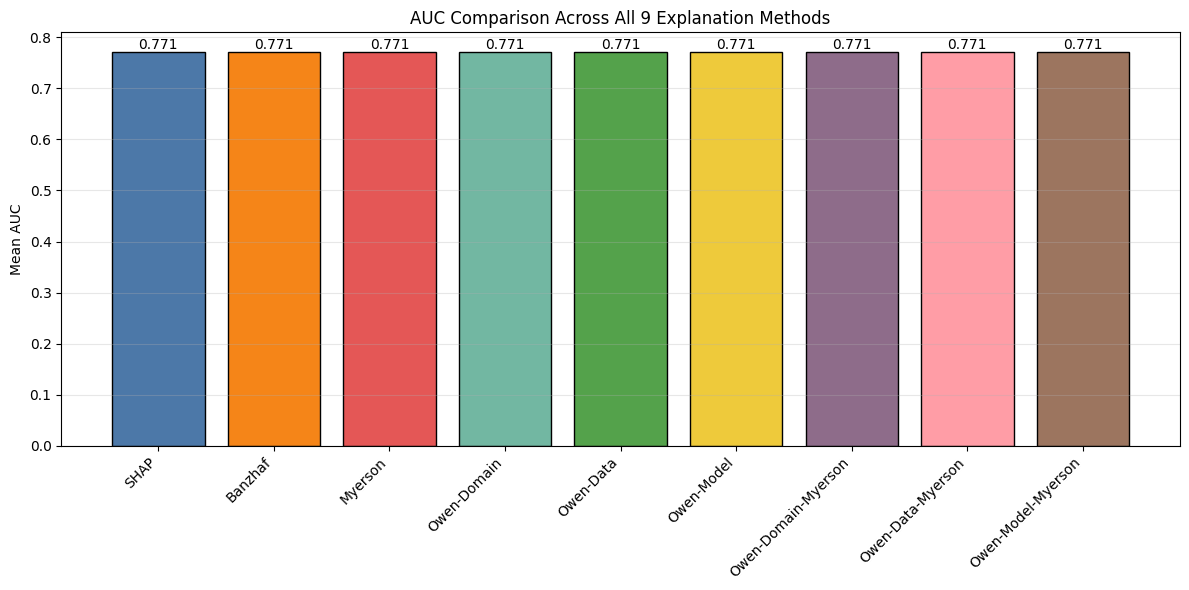

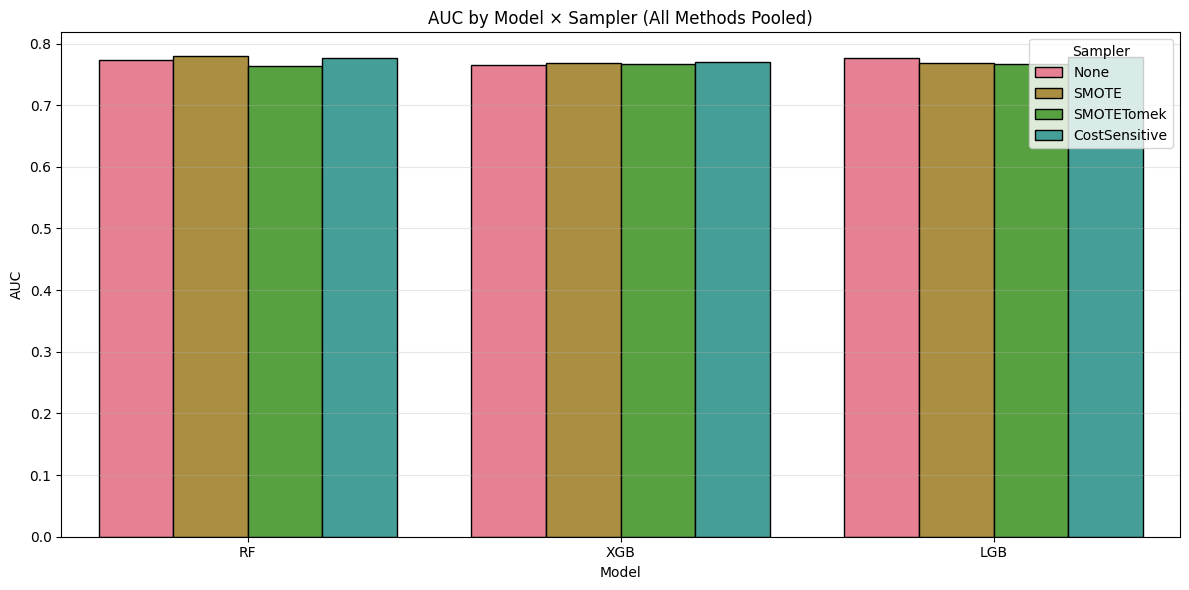

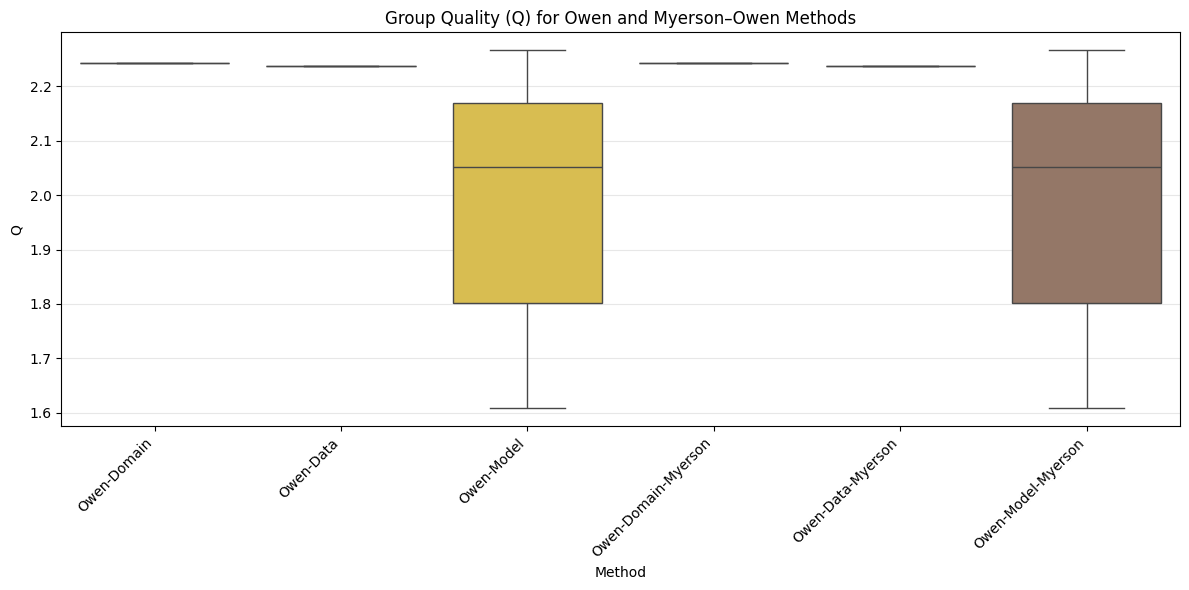

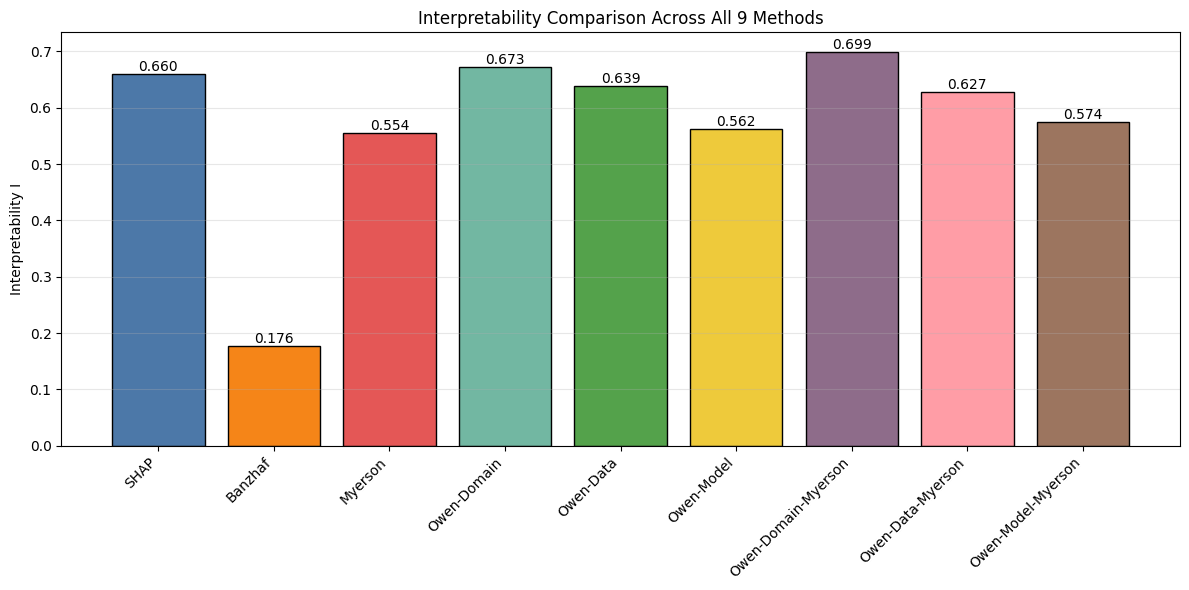

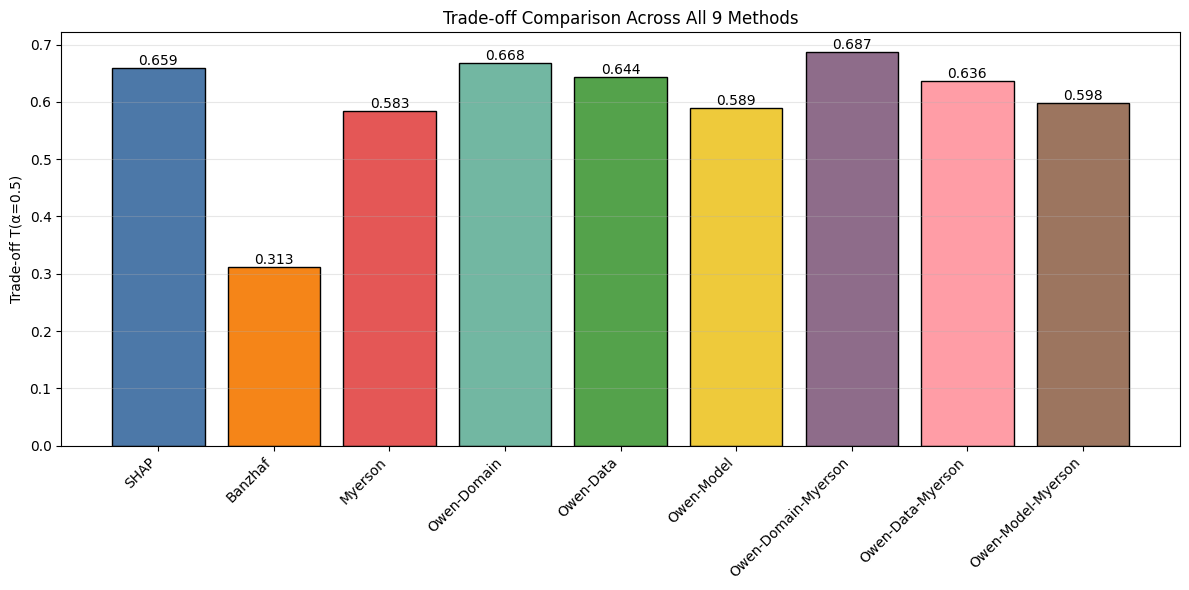

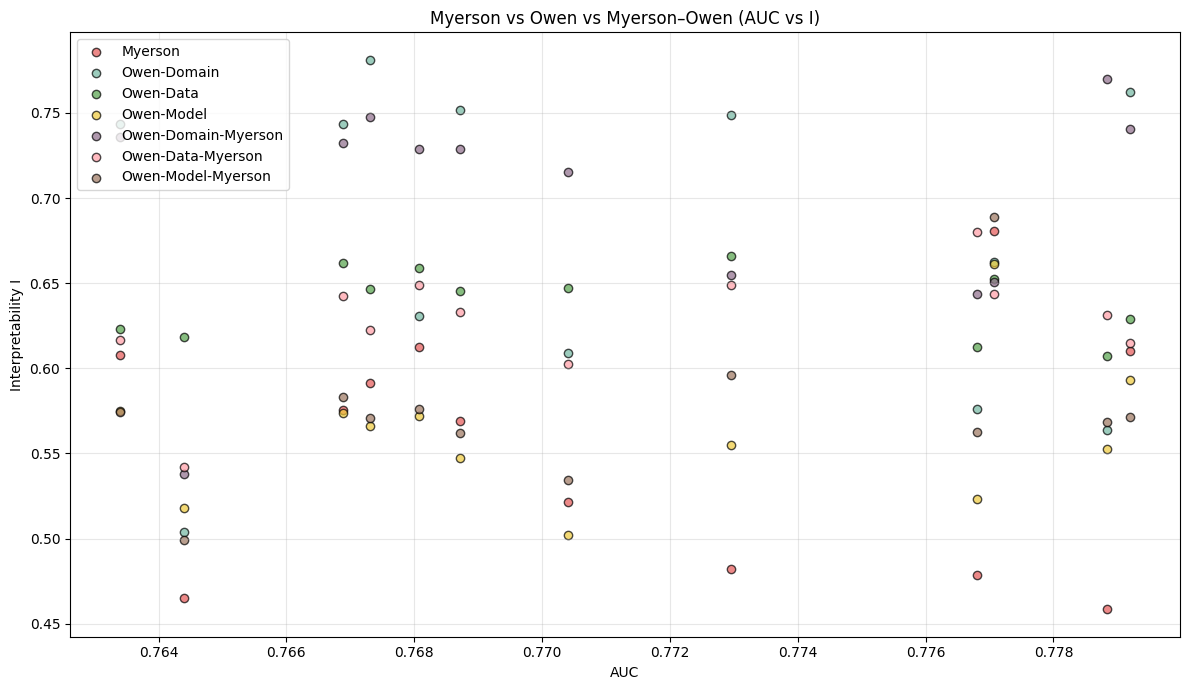


================ STATISTICAL VALIDATION ================

Spearman correlation (AUC vs I): ρ=0.0758, p=0.435581

Cliff’s Delta vs SHAP:
SHAP vs Banzhaf: δ=0.7361 (large)
SHAP vs Myerson: δ=0.2639 (small)
SHAP vs Owen-Domain: δ=-0.0417 (negligible)
SHAP vs Owen-Data: δ=0.0972 (negligible)
SHAP vs Owen-Model: δ=0.2917 (small)
SHAP vs Owen-Domain-Myerson: δ=-0.1111 (negligible)
SHAP vs Owen-Data-Myerson: δ=0.1389 (negligible)
SHAP vs Owen-Model-Myerson: δ=0.2500 (small)

Wilcoxon Tests (T(α=0.5)):
SHAP vs Banzhaf: p=0.000488 (SIGNIFICANT)
SHAP vs Myerson: p=0.001465 (SIGNIFICANT)
SHAP vs Owen-Domain: p=0.791016 (ns)
SHAP vs Owen-Data: p=0.063965 (ns)
SHAP vs Owen-Model: p=0.000488 (SIGNIFICANT)
SHAP vs Owen-Domain-Myerson: p=0.151367 (ns)
SHAP vs Owen-Data-Myerson: p=0.000488 (SIGNIFICANT)
SHAP vs Owen-Model-Myerson: p=0.000977 (SIGNIFICANT)

Friedman Test Across All Methods:
Methods: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model', 'Owen-Domain-Myerson', 'Owen-Da

In [3]:
# ============================================================
# UNIFIED COMPARISON MODULE FOR ALL 9 METHODS
# SHAP, BANZHAF, MYERSON, OWEN 3, MYERSON–OWEN 3
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare
import scikit_posthocs as sp

plt.style.use('default')
sns.set_palette("husl")

# ------------------------------------------------------------
# Load metrics if needed
# ------------------------------------------------------------
try:
    metrics
    print("Using existing metrics DataFrame.")
except NameError:
    print("Loading metrics from CSV...")
    metrics = pd.read_csv("german_unified_results_myerson_owen.csv")

metrics_g = metrics.copy()

# ------------------------------------------------------------
# Method ordering and colors
# ------------------------------------------------------------
method_order = [
    'SHAP', 'Banzhaf', 'Myerson',
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

method_colors = {
    'SHAP': '#4C78A8',
    'Banzhaf': '#F58518',
    'Myerson': '#E45756',
    'Owen-Domain': '#72B7A2',
    'Owen-Data': '#54A24B',
    'Owen-Model': '#EECA3B',
    'Owen-Domain-Myerson': '#8E6C8A',
    'Owen-Data-Myerson': '#FF9DA6',
    'Owen-Model-Myerson': '#9C755F'
}

# ============================================================
# 1. AUC COMPARISON
# ============================================================

plt.figure(figsize=(12, 6))
auc_means = metrics_g.groupby("Method")["AUC"].mean().reindex(method_order)
bars = plt.bar(auc_means.index, auc_means.values,
               color=[method_colors[m] for m in auc_means.index],
               edgecolor='black')
plt.bar_label(bars, fmt="%.3f")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean AUC")
plt.title("AUC Comparison Across All 9 Explanation Methods")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. MODEL–SAMPLER PERFORMANCE
# ============================================================

plt.figure(figsize=(12, 6))
sns.barplot(
    data=metrics_g,
    x="Model",
    y="AUC",
    hue="Sampler",
    ci=None,
    edgecolor='black'
)
plt.title("AUC by Model × Sampler (All Methods Pooled)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 3. GROUP QUALITY (Q) ANALYSIS
# ============================================================

owen_methods = [
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

owen_data = metrics_g[metrics_g["Method"].isin(owen_methods)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=owen_data,
    x="Method",
    y="Q",
    order=owen_methods,
    palette=[method_colors[m] for m in owen_methods]
)
plt.xticks(rotation=45, ha='right')
plt.title("Group Quality (Q) for Owen and Myerson–Owen Methods")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 4. OWEN-ONLY ANALYSIS (Interpretability & Trade-off)
# ============================================================

plt.figure(figsize=(12, 6))
I_means = metrics_g.groupby("Method")["I"].mean().reindex(method_order)
bars = plt.bar(I_means.index, I_means.values,
               color=[method_colors[m] for m in I_means.index],
               edgecolor='black')
plt.bar_label(bars, fmt="%.3f")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Interpretability I")
plt.title("Interpretability Comparison Across All 9 Methods")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
T_means = metrics_g.groupby("Method")["T(α=0.5)"].mean().reindex(method_order)
bars = plt.bar(T_means.index, T_means.values,
               color=[method_colors[m] for m in T_means.index],
               edgecolor='black')
plt.bar_label(bars, fmt="%.3f")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Trade-off T(α=0.5)")
plt.title("Trade-off Comparison Across All 9 Methods")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 5. MYERSON–OWEN HYBRID ANALYSIS
# ============================================================

subset = metrics_g[metrics_g["Method"].isin(
    ['Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model',
     'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson']
)]

plt.figure(figsize=(12, 7))
for m in subset["Method"].unique():
    sub = subset[subset["Method"] == m]
    plt.scatter(sub["AUC"], sub["I"], label=m,
                color=method_colors[m], edgecolors='black', alpha=0.7)

plt.xlabel("AUC")
plt.ylabel("Interpretability I")
plt.title("Myerson vs Owen vs Myerson–Owen (AUC vs I)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 6. STATISTICAL VALIDATION
# ============================================================

print("\n================ STATISTICAL VALIDATION ================\n")

# ------------------------------------------------------------
# Spearman correlation
# ------------------------------------------------------------
rho, p = spearmanr(metrics_g["AUC"], metrics_g["I"])
print(f"Spearman correlation (AUC vs I): ρ={rho:.4f}, p={p:.6f}")

# ------------------------------------------------------------
# Cliff’s Delta
# ------------------------------------------------------------
def cliffs_delta(x, y):
    x = np.array(x)
    y = np.array(y)
    n1, n2 = len(x), len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (n1 * n2)
    ad = abs(delta)
    if ad < 0.147:
        mag = "negligible"
    elif ad < 0.33:
        mag = "small"
    elif ad < 0.474:
        mag = "medium"
    else:
        mag = "large"
    return delta, mag

print("\nCliff’s Delta vs SHAP:")
for m in method_order:
    if m == "SHAP":
        continue
    x = metrics_g[metrics_g["Method"] == "SHAP"]["T(α=0.5)"]
    y = metrics_g[metrics_g["Method"] == m]["T(α=0.5)"]
    if len(x) > 1 and len(y) > 1:
        delta, mag = cliffs_delta(x, y)
        print(f"SHAP vs {m}: δ={delta:.4f} ({mag})")

# ------------------------------------------------------------
# Wilcoxon tests
# ------------------------------------------------------------
print("\nWilcoxon Tests (T(α=0.5)):")
pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('SHAP', 'Owen-Domain-Myerson'),
    ('SHAP', 'Owen-Data-Myerson'),
    ('SHAP', 'Owen-Model-Myerson')
]

for m1, m2 in pairs:
    d1 = metrics_g[metrics_g["Method"] == m1]["T(α=0.5)"]
    d2 = metrics_g[metrics_g["Method"] == m2]["T(α=0.5)"]
    if len(d1) == len(d2) and len(d1) > 1:
        stat, p = wilcoxon(d1, d2)
        sig = "SIGNIFICANT" if p < 0.05 else "ns"
        print(f"{m1} vs {m2}: p={p:.6f} ({sig})")

# ------------------------------------------------------------
# Friedman + Nemenyi
# ------------------------------------------------------------
print("\nFriedman Test Across All Methods:")

pivot = metrics_g.pivot_table(
    values="T(α=0.5)",
    index=["Model", "Sampler"],
    columns="Method",
    aggfunc="mean"
)

complete = pivot.dropna(axis=1).columns.tolist()
complete = [m for m in method_order if m in complete]

if len(complete) >= 3:
    data = pivot[complete].values
    stat, p = friedmanchisquare(*[data[:, i] for i in range(data.shape[1])])
    print(f"Methods: {complete}")
    print(f"Friedman χ²={stat:.4f}, p={p:.6f}")
    if p < 0.05:
        print("→ Significant differences detected")
        nemenyi = sp.posthoc_nemenyi_friedman(data)
        nemenyi.index = complete
        nemenyi.columns = complete
        print("\nNemenyi Post-hoc Test:")
        print(nemenyi.round(4))
    else:
        print("→ No significant differences")
else:
    print("Not enough complete methods for Friedman test.")


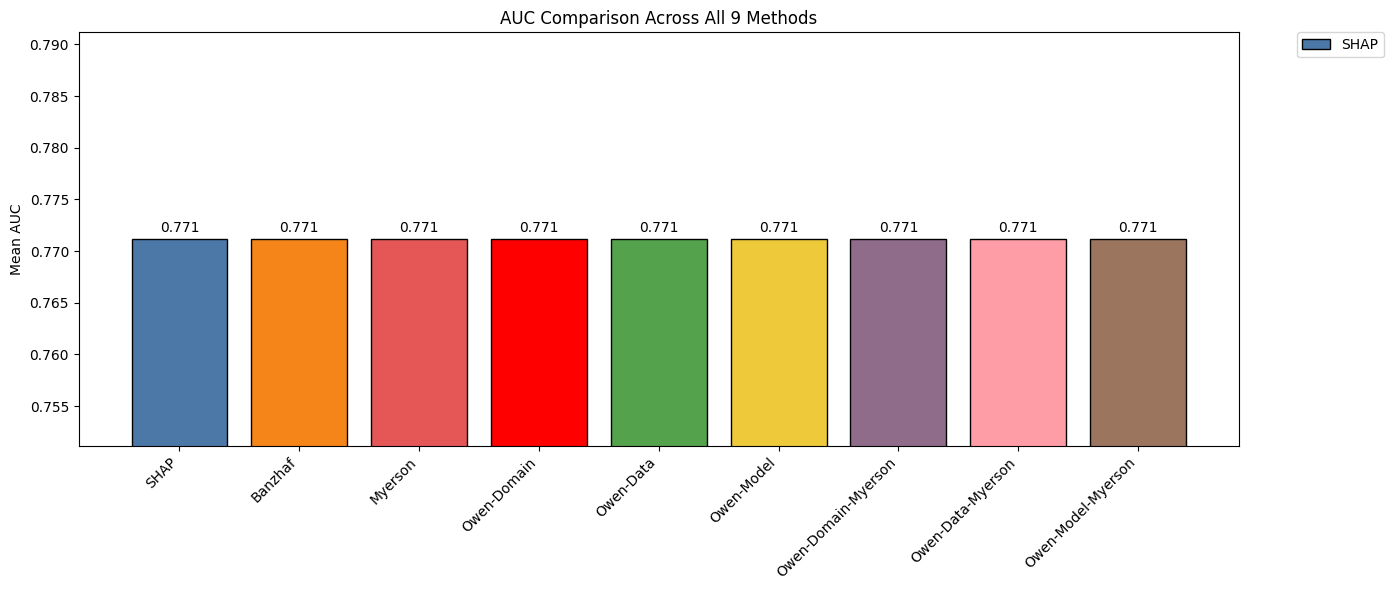

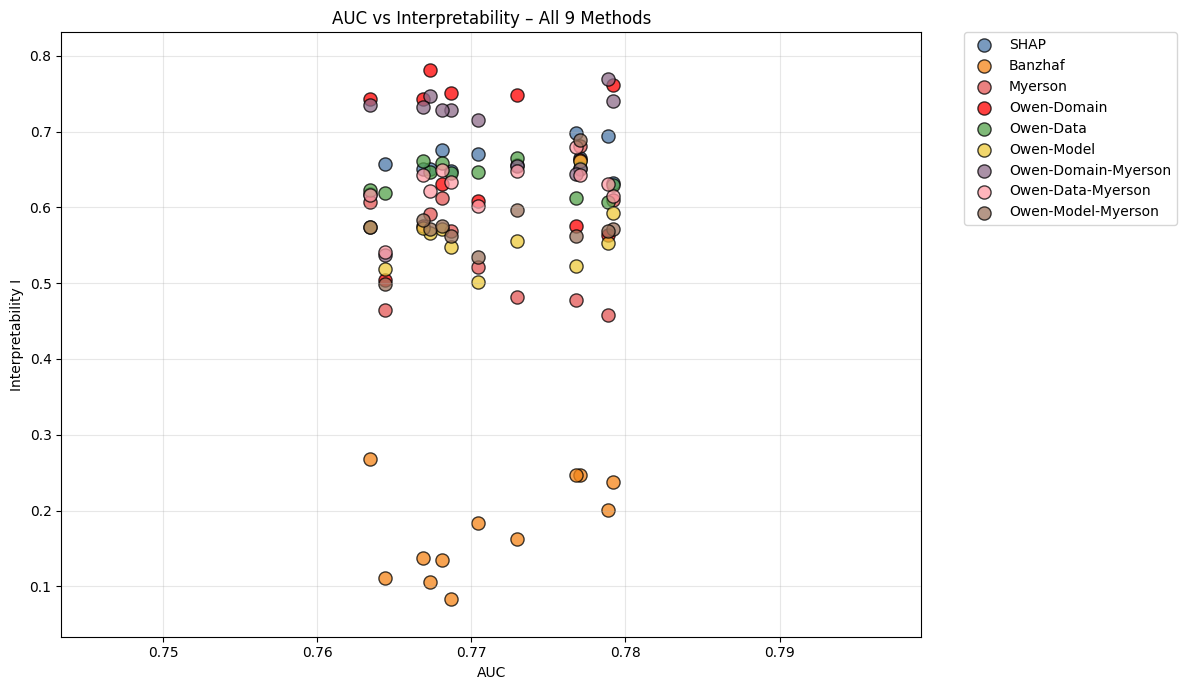

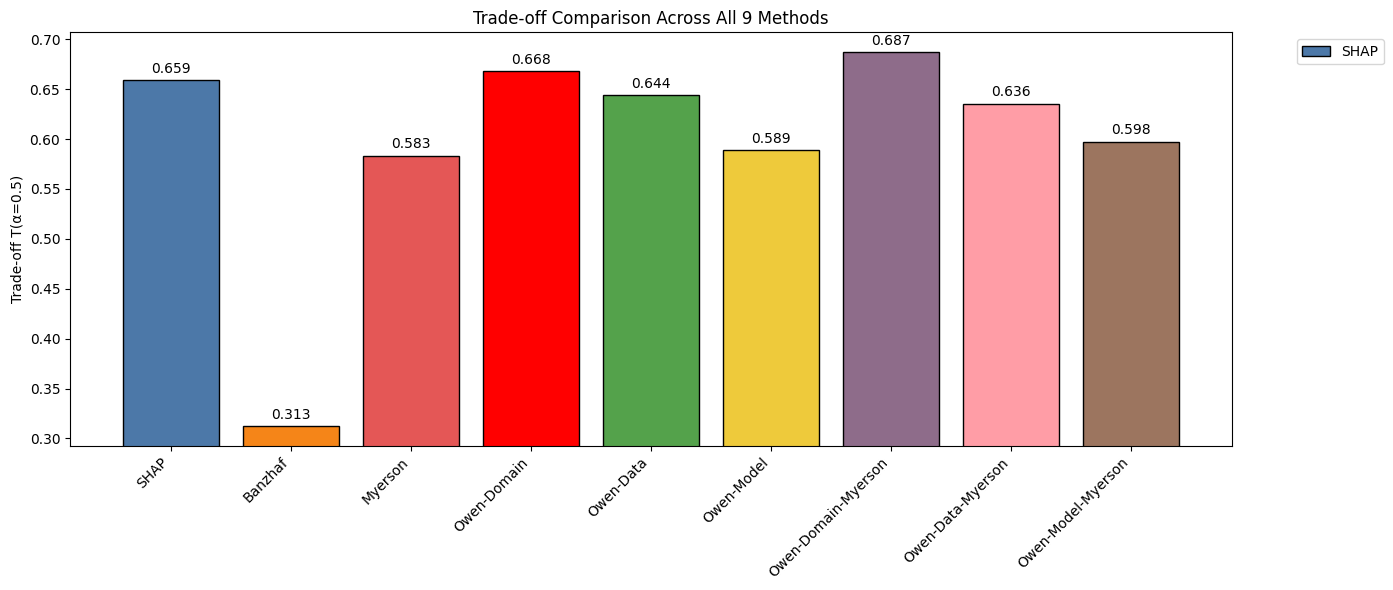

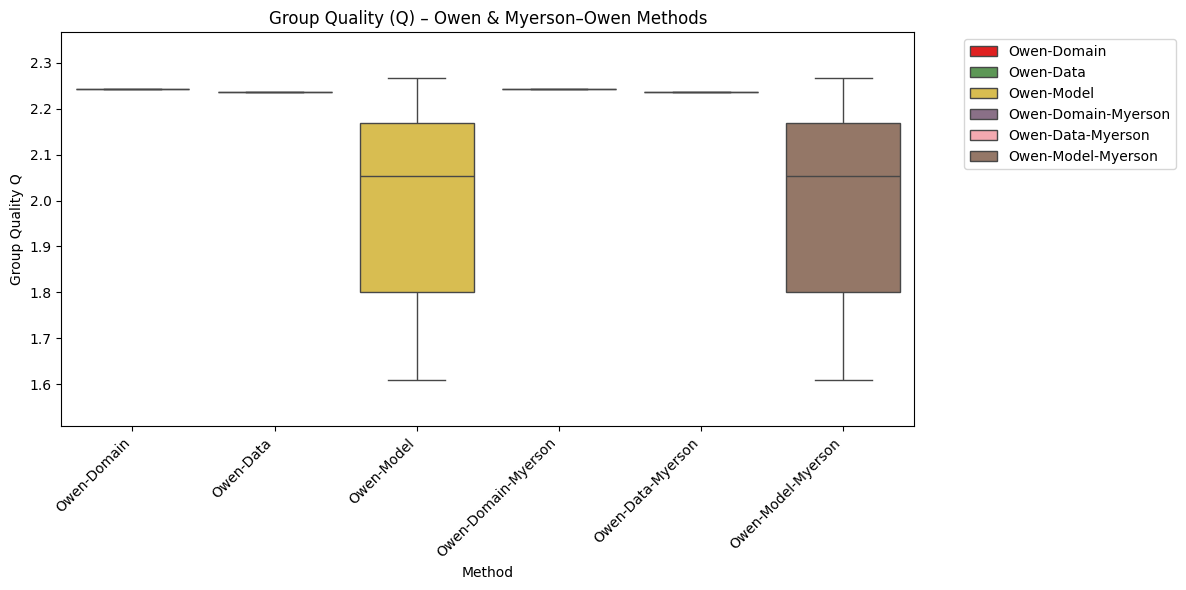

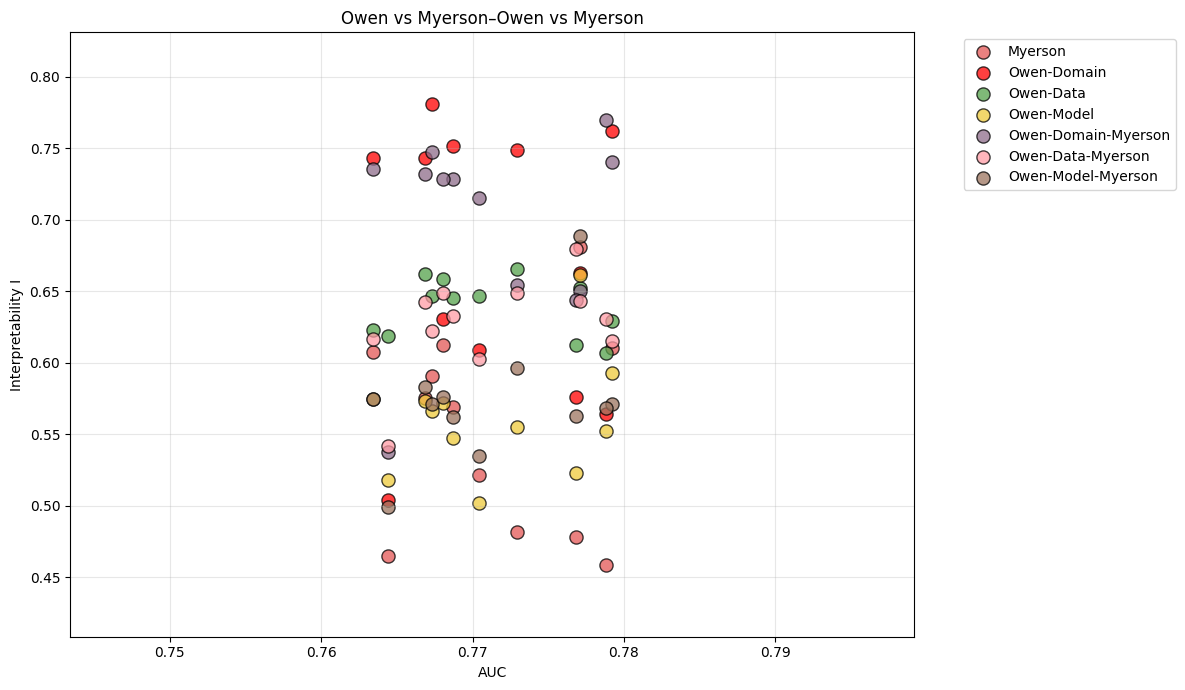

In [4]:
# ============================================================
# UPDATED VISUALIZATION MODULE – LEGENDS OUTSIDE, CLEAR AXES,
# OWEN-DOMAIN IN RED, ALL 9 METHODS COMPARED
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# If metrics not in memory, load it
try:
    metrics_g
except:
    metrics_g = pd.read_csv("german_unified_results_myerson_owen.csv")

# ------------------------------------------------------------
# Method ordering and colors (Owen-Domain = RED)
# ------------------------------------------------------------
method_order = [
    'SHAP', 'Banzhaf', 'Myerson',
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

method_colors = {
    'SHAP': '#4C78A8',
    'Banzhaf': '#F58518',
    'Myerson': '#E45756',
    'Owen-Domain': '#FF0000',          # RED
    'Owen-Data': '#54A24B',
    'Owen-Model': '#EECA3B',
    'Owen-Domain-Myerson': '#8E6C8A',
    'Owen-Data-Myerson': '#FF9DA6',
    'Owen-Model-Myerson': '#9C755F'
}

# ============================================================
# 1. AUC COMPARISON (LEGEND OUTSIDE)
# ============================================================

plt.figure(figsize=(14, 6))
auc_means = metrics_g.groupby("Method")["AUC"].mean().reindex(method_order)

bars = plt.bar(
    auc_means.index,
    auc_means.values,
    color=[method_colors[m] for m in auc_means.index],
    edgecolor='black'
)

plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean AUC")
plt.title("AUC Comparison Across All 9 Methods")

# Expand y-axis for clarity
plt.ylim(auc_means.min() - 0.02, auc_means.max() + 0.02)

# Legend outside
plt.legend(
    auc_means.index,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

# ============================================================
# 2. AUC vs I SCATTER (LEGEND OUTSIDE)
# ============================================================

plt.figure(figsize=(12, 7))

for m in method_order:
    sub = metrics_g[metrics_g["Method"] == m]
    plt.scatter(
        sub["AUC"],
        sub["I"],
        label=m,
        color=method_colors[m],
        edgecolors='black',
        alpha=0.75,
        s=90
    )

plt.xlabel("AUC")
plt.ylabel("Interpretability I")
plt.title("AUC vs Interpretability – All 9 Methods")

# Expand axes for visibility
plt.xlim(metrics_g["AUC"].min() - 0.02, metrics_g["AUC"].max() + 0.02)
plt.ylim(metrics_g["I"].min() - 0.05, metrics_g["I"].max() + 0.05)

# Legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 3. TRADE-OFF T(α=0.5) COMPARISON (LEGEND OUTSIDE)
# ============================================================

plt.figure(figsize=(14, 6))
T_means = metrics_g.groupby("Method")["T(α=0.5)"].mean().reindex(method_order)

bars = plt.bar(
    T_means.index,
    T_means.values,
    color=[method_colors[m] for m in T_means.index],
    edgecolor='black'
)

plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Trade-off T(α=0.5)")
plt.title("Trade-off Comparison Across All 9 Methods")

plt.ylim(T_means.min() - 0.02, T_means.max() + 0.02)

plt.legend(
    T_means.index,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

# ============================================================
# 4. GROUP QUALITY Q (OWEN + MYERSON-OWEN)
# ============================================================

owen_methods = [
    'Owen-Domain', 'Owen-Data', 'Owen-Model',
    'Owen-Domain-Myerson', 'Owen-Data-Myerson', 'Owen-Model-Myerson'
]

owen_data = metrics_g[metrics_g["Method"].isin(owen_methods)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=owen_data,
    x="Method",
    y="Q",
    order=owen_methods,
    palette=[method_colors[m] for m in owen_methods]
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Group Quality Q")
plt.title("Group Quality (Q) – Owen & Myerson–Owen Methods")

plt.ylim(owen_data["Q"].min() - 0.1, owen_data["Q"].max() + 0.1)

plt.legend(
    owen_methods,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

# ============================================================
# 5. OWEN vs MYERSON–OWEN (SCATTER)
# ============================================================

subset = metrics_g[metrics_g["Method"].isin(owen_methods + ['Myerson'])]

plt.figure(figsize=(12, 7))

for m in subset["Method"].unique():
    sub = subset[subset["Method"] == m]
    plt.scatter(
        sub["AUC"], sub["I"],
        label=m,
        color=method_colors[m],
        edgecolors='black',
        alpha=0.75,
        s=90
    )

plt.xlabel("AUC")
plt.ylabel("Interpretability I")
plt.title("Owen vs Myerson–Owen vs Myerson")

plt.xlim(subset["AUC"].min() - 0.02, subset["AUC"].max() + 0.02)
plt.ylim(subset["I"].min() - 0.05, subset["I"].max() + 0.05)

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
